# USNM 2P data analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [3]:
%load_ext autoreload
%autoreload 2

## Imports

In [4]:
# External packages
import logging
import os
import pprint
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack, view_interactive_plot
from filters import KalmanDenoiser, NoFilter
from interpolators import StackInterpolator, NoInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()

# Logger level
logger.setLevel(logging.INFO)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


## General parameters

 13/12/2021 17:27:23: input data directory:
/Users/tlemaire/Documents/data/yiyuan/raw/new_experiments_201911/11122019/mouse12/region1
 13/12/2021 17:27:23: figures directory:
/Users/tlemaire/Documents/data/yiyuan/figs


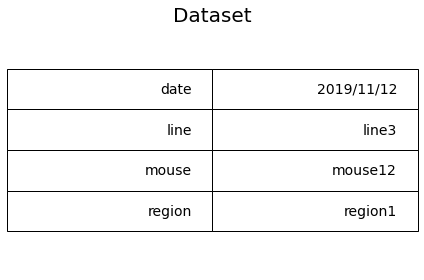

In [5]:
# Input data directory
dataroot = get_data_root() # Root directory for raw data
date = '11122019'
mouse = 'mouse12'
region = 'region1'
line = 'line3'
datadir = os.path.join(dataroot, date, mouse, region)
logger.info(f'input data directory:\n{datadir}')

# Figures dictionary
figsdir = os.path.join(split_path_at(dataroot, 'raw')[0], 'figs')
if not os.path.isdir(figsdir):
    os.makedirs(figsdir)
logger.info(f'figures directory:\n{figsdir}')
figs = {}

# Create table figure summarizing dataset info
figs['dataset_info'] = plot_table({
    'date': f'{date[4:]}/{date[:2]}/{date[2:4]}',
    'line': line,
    'mouse': mouse,
    'region': region
    })

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [6]:
# Get raw list of subolders containing tifs
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References'], include_patterns=[line])
logger.info(f'Identified folders containing TIF files:\n{pprint.pformat([os.path.basename(x) for x in tif_folders])}')

 13/12/2021 17:27:23: Identified folders containing TIF files:
['line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860',
 'line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862',
 'line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-861',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-858',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-863',
 'line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-867',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-857',
 'line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-868',
 'line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-864',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-859',
 'line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-866']


In [7]:
logger.info('extracting aquisition settings...')
daq_settings = parse_aquisition_settings(tif_folders)
daq_settings

 13/12/2021 17:27:23: extracting aquisition settings...


{'activeMode': 'Galvo',
 'bitDepth': 12.0,
 'currentScanAmplitude': {'XAxis': 7.6, 'YAxis': -7.6},
 'currentScanCenter': {'XAxis': 0.0, 'YAxis': 0.0},
 'daq': ('10x', 'Gain10'),
 'dwellTime': 2.8,
 'framePeriod': 0.280453201144955,
 'interlacedScanTrackCount': 0.0,
 'laserPower': (311.0, 'Pockels'),
 'laserWavelength': (920.0, 'Insight'),
 'linesPerFrame': 256.0,
 'maxVoltage': {'XAxis': 3.19540637796412, 'YAxis': -3.19540637796412},
 'micronsPerPixel': 1.96865654688785,
 'minVoltage': {'XAxis': -3.19540637796412, 'YAxis': 3.19540637796412},
 'objectiveLens': 'Olympus 10X',
 'objectiveLensMag': 10.0,
 'objectiveLensNA': 1.0,
 'opticalZoom': 2.37841423000544,
 'pixelsPerLine': 256.0,
 'pmtGain': {'PMT 1 HV': 0.0, 'PMT 2 HV': 394.7021276596, 'PMT 3 HV': 0.0},
 'positionCurrent': {'XAxis': 1.11, 'YAxis': 2.06, 'ZAxis': 0.05},
 'preampFilter': ('Filter1250KHz', '1.25 MHz'),
 'preampGain': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'preampOffset': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'rasters

### Merge TIFs into stack

In [8]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

 13/12/2021 17:27:25: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 13/12/2021 17:27:25: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 13/12/2021 17:27:25: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 13/12/2021 17:27:25: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 13/12/2021 17:27:25: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 13/12/2021 17:27:26: "/Users/tlemaire/Documents/data/yiyuan/stac

### Visualize stack for a randomly chosen run

 13/12/2021 17:27:27: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif"
 13/12/2021 17:27:28: plotting stack(s) histogram...
 13/12/2021 17:27:29: computing stack(s) fft...
 13/12/2021 17:27:32: plotting stack(s) frequency spectrum...
 13/12/2021 17:27:32: initializing stack viewer
 13/12/2021 17:27:32: stack size: (1600, 256, 256)
 13/12/2021 17:27:32: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5216.01it/s]

 13/12/2021 17:27:33: intensity range: 19 - 2280
 13/12/2021 17:27:33: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 3937.12it/s]

 13/12/2021 17:27:33: initializing stack viewer
 13/12/2021 17:27:33: stack size: (1600, 256, 256)
 13/12/2021 17:27:33: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5597.91it/s]

 13/12/2021 17:27:33: intensity range: 19 - 2280
 13/12/2021 17:27:33: rendering stack view...


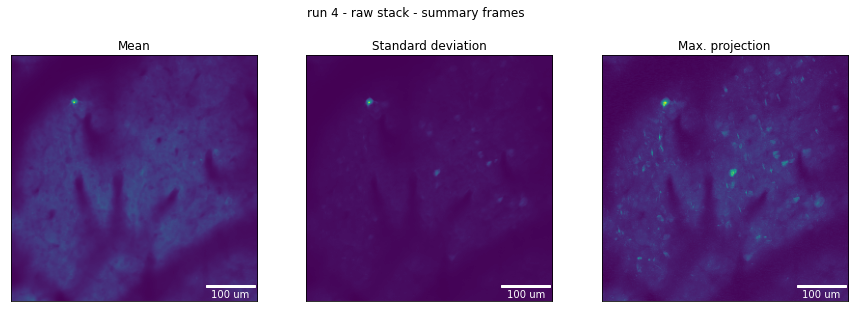

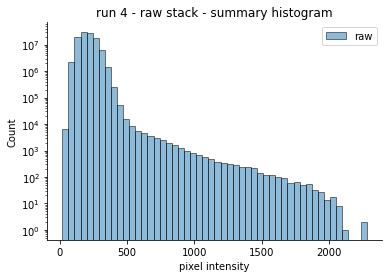

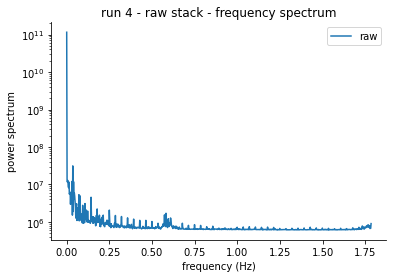

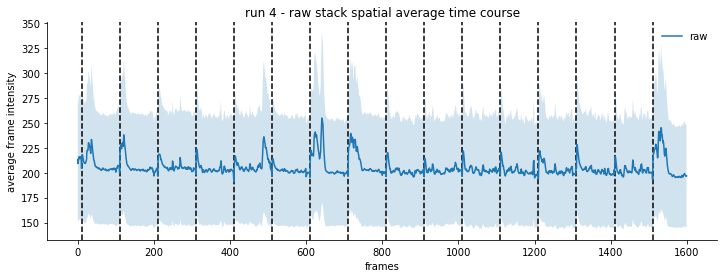

In [9]:
# Run index
irun = 4

from plotters import plot_stack_timecourse

# Load stack
raw_stack = loadtif(raw_stack_fpaths[irun])

# Plot stack summary frames
figs[f'raw_stack_frames_run{irun}'] = plot_stack_summary_frames(
    raw_stack, title=f'run {irun} - raw stack',
    um_per_px=daq_settings['micronsPerPixel'])

# Plot stack histogram
figs[f'raw_stack_hist_run{irun}'] = plot_stack_histogram(
    {'raw': raw_stack}, title=f'run {irun} - raw stack')

# Plot stack frequency spectrum
figs[f'raw_stack_fspectrum_run{irun}'] = plot_stack_frequency_spectrum(
    {'raw': raw_stack},  1 / daq_settings['framePeriod'], title=f'run {irun} - raw stack')

# Plot time course of the stack spatial average
figs[f'raw_stack_timecourse_run{irun}'] = plot_stack_timecourse(
    {'raw': raw_stack_fpaths[irun]},
    ilabels=i_stim_frames_run, title=f'run {irun} - raw stack')

# View stack 
view_stack({
    'raw': raw_stack_fpaths[irun]}, title=f'run {irun}', ilabels=i_stim_frames_run)

We notice a significant amount of Speckle noise in the acquired images, especially on the frames corresponding to stimulation episodes.

## Substitution of stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we substitute them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

In [10]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Substitute stim frames every TIF stack and save outputs in specific directory 
input_root = 'stacked'
substituted_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, i_stim_frames_run, overwrite=False)

 13/12/2021 17:27:34: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 13/12/2021 17:27:34: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 13/12/2021 17:27:34: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 13/12/2021 17:27:34: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 13/12/2021 17:27:34: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200

### View stack substitution output for the same run

 13/12/2021 17:27:34: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif"
 13/12/2021 17:27:35: plotting stack(s) histogram...
 13/12/2021 17:27:38: computing stack(s) fft...
 13/12/2021 17:27:44: plotting stack(s) frequency spectrum...
 13/12/2021 17:27:44: initializing stack viewer
 13/12/2021 17:27:44: stack size: (1600, 256, 256)
 13/12/2021 17:27:44: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5853.41it/s]

 13/12/2021 17:27:44: intensity range: 19 - 2280



100%|██████████| 1600/1600 [00:00<00:00, 5749.91it/s]

 13/12/2021 17:27:44: intensity range: 19 - 2280
 13/12/2021 17:27:44: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 4115.20it/s]

 13/12/2021 17:27:45: initializing stack viewer
 13/12/2021 17:27:45: stack size: (1600, 256, 256)
 13/12/2021 17:27:45: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5818.71it/s]

 13/12/2021 17:27:45: intensity range: 19 - 2280



100%|██████████| 1600/1600 [00:00<00:00, 5828.40it/s]

 13/12/2021 17:27:46: intensity range: 19 - 2280
 13/12/2021 17:27:46: rendering stack view...


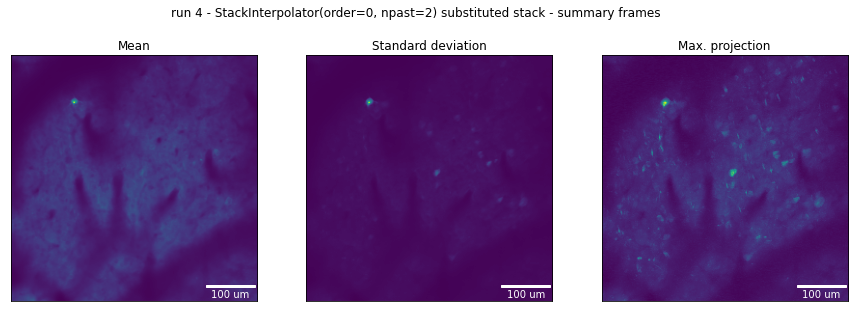

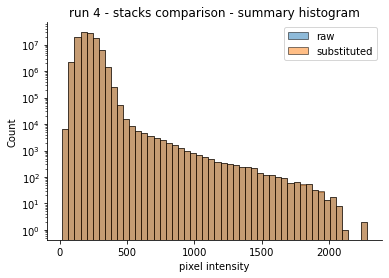

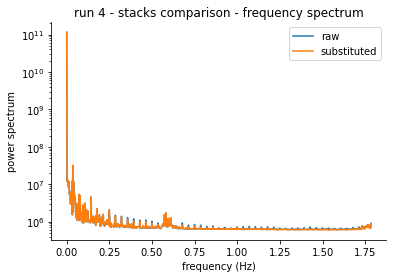

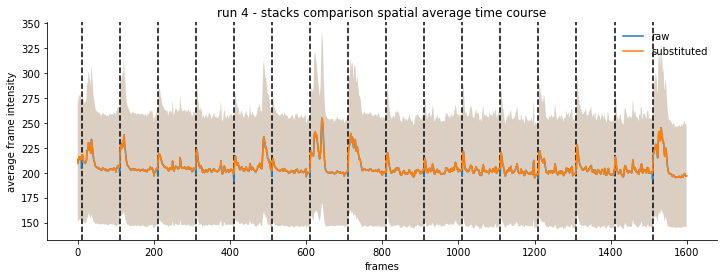

In [11]:
# Load interpolated stack for the same run
subsituted_stack = loadtif(substituted_stack_fpaths[irun])

# Plot interpolated stack summary frames
figs[f'interp_stack_frames_run{irun}'] = plot_stack_summary_frames(
    subsituted_stack, title=f'run {irun} - {si} substituted stack',
    um_per_px=daq_settings['micronsPerPixel'])

# Plot stack histogram
figs[f'interp_stack_hist_run{irun}'] = plot_stack_histogram(
    {'raw': raw_stack, 'substituted': subsituted_stack},
    title=f'run {irun} - stacks comparison')

# Plot stack frequency spectrum
figs[f'interp_stack_fspectrum_run{irun}'] = plot_stack_frequency_spectrum(
        {'raw': raw_stack, 'substituted': subsituted_stack},
        1 / daq_settings['framePeriod'], title=f'run {irun} - stacks comparison')

# Plot comparative time course of the stacks spatial average
figs[f'interp_stack_timecourse_run{irun}'] = plot_stack_timecourse({
    'raw': raw_stack_fpaths[irun],
    'substituted': substituted_stack_fpaths[irun]
    }, ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')

# Visualize raw and inteprolated stacks side-by-side
view_stack({
    'raw': raw_stack_fpaths[irun],
    si: substituted_stack_fpaths[irun]},
    title=f'run {irun}', ilabels=i_stim_frames_run, norm=True)

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [12]:
# Define Kalman filter
kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
# kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'stacked' if isinstance(si, NoInterpolator) else si.rootcode
filtered_stack_fpaths = process_and_save(kd, substituted_stack_fpaths, input_root, overwrite=False)

 13/12/2021 17:27:47: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 13/12/2021 17:27:47: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 13/12/2021 17:27:47: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 13/12/2021 17:27:47: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 13/12/2021 17:27:47: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_or

### View stack denoising output for a particular stack

 13/12/2021 17:27:47: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif"
 13/12/2021 17:27:47: plotting stack(s) histogram...
 13/12/2021 17:27:50: computing stack(s) fft...
 13/12/2021 17:27:56: plotting stack(s) frequency spectrum...
 13/12/2021 17:27:56: initializing stack viewer
 13/12/2021 17:27:56: stack size: (1600, 256, 256)
 13/12/2021 17:27:56: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5260.58it/s]

 13/12/2021 17:27:56: intensity range: 19 - 2280



100%|██████████| 1600/1600 [00:00<00:00, 5606.46it/s]

 13/12/2021 17:27:56: intensity range: 48 - 2124
 13/12/2021 17:27:56: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 4114.25it/s]

 13/12/2021 17:27:57: initializing stack viewer
 13/12/2021 17:27:57: stack size: (1600, 256, 256)
 13/12/2021 17:27:57: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5795.88it/s]

 13/12/2021 17:27:58: intensity range: 19 - 2280



100%|██████████| 1600/1600 [00:00<00:00, 5818.67it/s]

 13/12/2021 17:27:58: intensity range: 48 - 2124
 13/12/2021 17:27:58: rendering stack view...


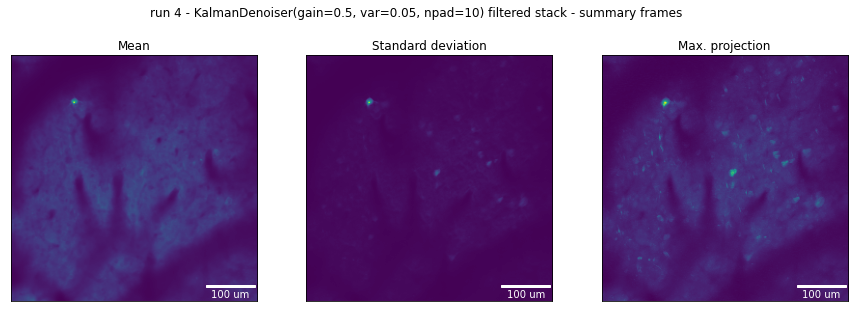

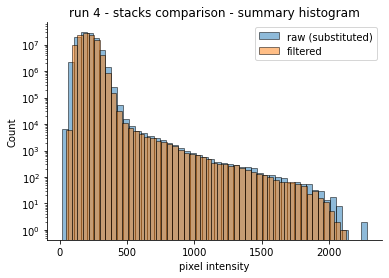

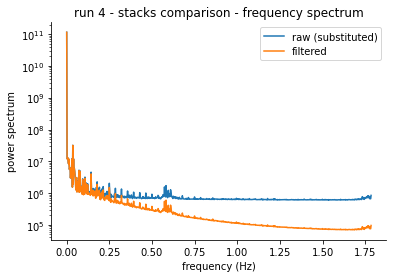

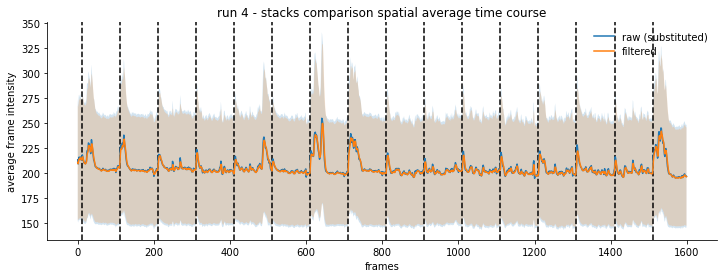

In [13]:
# Load denoised stack for the same run
filtered_stack = loadtif(filtered_stack_fpaths[irun])

# Plot denoised stack summary frames
figs[f'filtered_stack_frames_run{irun}'] = plot_stack_summary_frames(
    filtered_stack, title=f'run {irun} - {kd} filtered stack',
    um_per_px=daq_settings['micronsPerPixel'])

# Plot comparative stack histograms
figs[f'filtered_stack_hist_run{irun}'] = plot_stack_histogram(
    {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
    title=f'run {irun} - stacks comparison')

# Plot stack frequency spectrum
figs[f'filtered_stack_fspectrum_run{irun}'] = plot_stack_frequency_spectrum(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
        1 / daq_settings['framePeriod'], title=f'run {irun} - stacks comparison')

# Plot comparative time course of the stacks spatial average
figs[f'filtered_stack_timecourse_run{irun}'] = plot_stack_timecourse({
    'raw (substituted)': substituted_stack_fpaths[irun],
    'filtered': filtered_stack_fpaths[irun]
    }, ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')

# Visualize raw, inteprolated and denoised stacks side-by-side
view_stack({
    'raw (substituted)': substituted_stack_fpaths[irun],
    kd: filtered_stack_fpaths[irun]},
    ilabels=i_stim_frames_run, norm=True)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [14]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

 13/12/2021 17:27:59: parsed frame rate = 3.56 fps
 13/12/2021 17:27:59: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1


### Run suite2p with custom options

In [15]:
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

 13/12/2021 17:27:59: running suite2p 0.10.2 with the following options:
{'denoise': False,
 'do_registration': 1,
 'fs': 3.56,
 'nonrigid': True,
 'reg_tif': True,
 'tau': 1.25}
 13/12/2021 17:27:59: data will be saved in suite2p base directory "suite2p_fs_3.56_reg_tif_tau_1.25"
 13/12/2021 17:27:59: found suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/plane0"
 13/12/2021 17:27:59: run options match 100% -> ignoring
 13/12/2021 17:27:59: empty data path -> no run


### Load suite2p ouput data

In [16]:
# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
all_s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = all_s2p_data.pop('ops')
outstack_label = get_s2p_stack_label(s2p_ops)

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Log info table
logger.info('output info table corresponding to suite2p processing order:')
output_info_table

 13/12/2021 17:27:59: extracted data contains 880 ROIs
 13/12/2021 17:27:59: output info table corresponding to suite2p processing order:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  ntrials
run                                                                           
0    line3           100           0.2  3.56     0.00    50.0     869       16
1    line3           100           0.2  3.56     0.10    50.0     867       16
2    line3           100           0.2  3.56     0.20    50.0     866       16
3    line3           100           0.2  3.56     0.40    50.0     865       16
4    line3           100           0.2  3.56     0.05    50.0     868       16
5    line3           100           0.2  3.56     0.60    50.0     864       16
6    line3           100           0.2  3.56     0.80     5.0     860       16
7    line3           100           0.2  3.56     0.80    10.0     859       16
8    line3           100           0.2  3.56     0.80    20.0     858       16
9    line3           100           0.2  3.56     0.80    30.0     857       16
10   line3           100           0.2  3.56     0.80    40.0     856       16
11   line3           100           0.2  3.56     0.80    50.0     855       16
12   line3           100           0.2  3.56     0.80    60.0     861       16
13   line3           100           0.2  3.56     0.80    70.0     862       16
14   line3           100           0.2  3.56     0.80    80.0     863       16

### Plot suite2p summary images

 13/12/2021 17:27:59: plotting suite2p registered images...


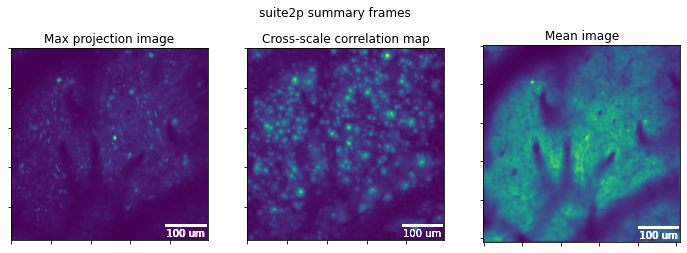

In [17]:
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=daq_settings['micronsPerPixel'])

### Plot suite2p registration offsets

 13/12/2021 17:27:59: plotting suite2p registration offsets...
 13/12/2021 17:27:59: plotting suite2p registration phase correlation peaks...


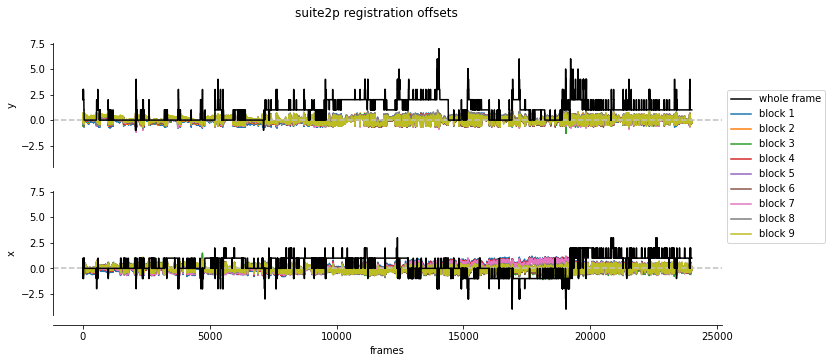

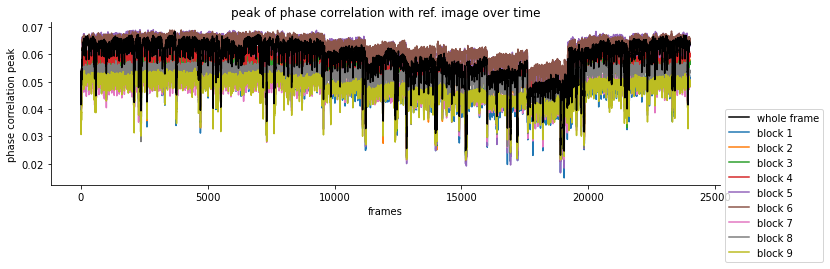

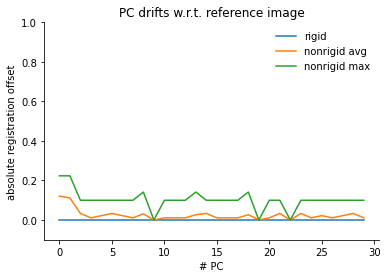

In [18]:
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, title='suite2p registration offsets')
figs['phasecorrpeak_over_time'] = plot_suite2p_phase_corr_peak(s2p_ops)
figs['PCdrifts'] = plot_suite2p_PC_drifts(s2p_ops)

### Visualize registered stack (for the same run as before)

In [19]:
istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
for i in range(nruns):
    istimframes_stacked[i] += i * nframes_per_run
istimframes_stacked = istimframes_stacked.flatten()
irun_eq = output_to_input_mapping[irun]
runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
view_stack(
    s2p_ops, title=f'{outstack_label} stack (run {irun} -> output {irun_eq})',
    bounds=runbounds, ilabels=istimframes_stacked)

 13/12/2021 17:28:00: initializing stack viewer
 13/12/2021 17:28:00: stack size: (24000, 256, 256)
 13/12/2021 17:28:00: frame frange: [20800, 22399]
 13/12/2021 17:28:00: computing stack intensity range across 20800 - 22399 frame range...


100%|██████████| 1600/1600 [00:01<00:00, 1392.93it/s]

 13/12/2021 17:28:01: intensity range: 52.0 - 1768.0
 13/12/2021 17:28:01: rendering stack view...


### Plot stack histogram & frequency spectrum

 13/12/2021 17:28:01: loading suite2p binary stack...
 13/12/2021 17:28:03: extracting [20800, 22399] stack slice...
 13/12/2021 17:28:04: plotting stack(s) histogram...
 13/12/2021 17:28:07: computing stack(s) fft...
 13/12/2021 17:28:14: plotting stack(s) frequency spectrum...


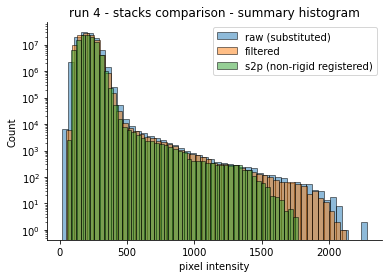

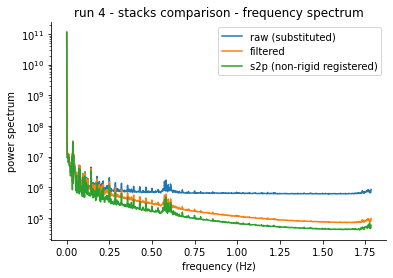

In [20]:
registered_stack = get_s2p_stack(s2p_ops, bounds=runbounds)
# Plot stack histogram
figs[f'registered_stack_hist_run{irun}'] = plot_stack_histogram(
    {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
    title=f'run {irun} - stacks comparison')
# Plot stack frequency spectrum
figs[f'registered_stack_fspectrum_run{irun}'] = plot_stack_frequency_spectrum(
    {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
    1 / daq_settings['framePeriod'], title=f'run {irun} - stacks comparison')

### Compare average frame intensity for specific run

That is a good opportunity to check that our mapping of input stacks to suite2p output stacks is correct.

 13/12/2021 17:28:15: initializing stack viewer
 13/12/2021 17:28:15: stack size: (1600, 256, 256)
 13/12/2021 17:28:15: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 4752.87it/s]

 13/12/2021 17:28:15: intensity range: 19 - 2280



100%|██████████| 1600/1600 [00:00<00:00, 4976.16it/s]

 13/12/2021 17:28:16: intensity range: 48 - 2124
 13/12/2021 17:28:16: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 4050.38it/s]

 13/12/2021 17:28:16: initializing stack viewer
 13/12/2021 17:28:16: stack size: (24000, 256, 256)
 13/12/2021 17:28:16: frame frange: [20800, 22399]
 13/12/2021 17:28:16: computing stack intensity range across 20800 - 22399 frame range...



100%|██████████| 1600/1600 [00:02<00:00, 776.68it/s]

 13/12/2021 17:28:18: intensity range: 52.0 - 1768.0



100%|██████████| 1600/1600 [00:02<00:00, 794.27it/s]


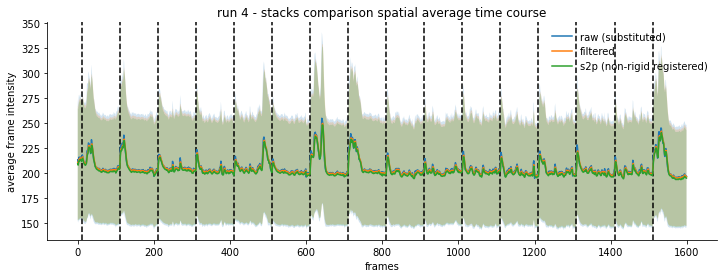

In [21]:
# Plot comparative time course of the stacks spatial average
correct = False
fig = plot_stack_timecourse({
    'raw (substituted)': substituted_stack_fpaths[irun],
    'filtered': filtered_stack_fpaths[irun]
    },
    correct=correct,
    ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')
figs[f'registered_stack_timecourse_run{irun}'] = plot_stack_timecourse(
    s2p_ops, title=outstack_label, bounds=runbounds, ax=fig.axes[0], correct=correct)

### Inspect sparse detection maps

 13/12/2021 17:28:21: plotting suite2p sparse projection maps...


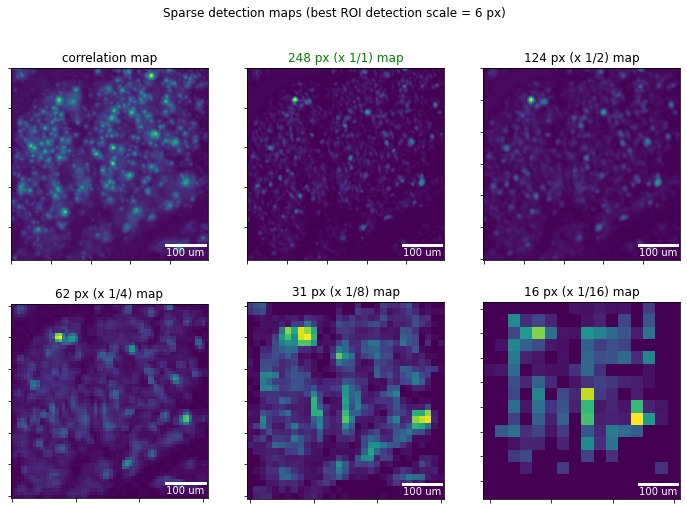

In [22]:
figs['sparse_maps'] = plot_suite2p_sparse_maps(
    s2p_ops, um_per_px=daq_settings['micronsPerPixel'])

### Inspect suite2p ROIs

 13/12/2021 17:28:21: plotting suite2p identified ROIs...


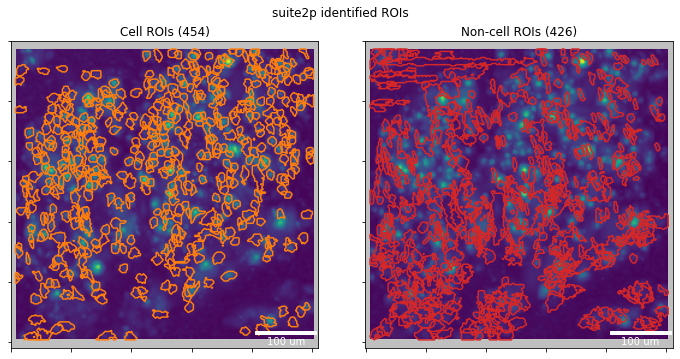

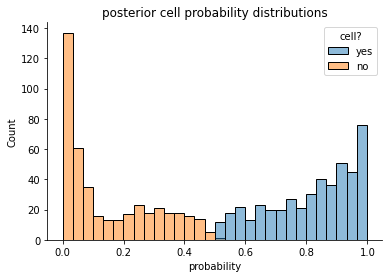

In [23]:
figs['identified_ROIs'] = plot_suite2p_ROIs(
    all_s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=daq_settings['micronsPerPixel'], mode='contour')
figs['ROI_prob_dists'] = plot_suite2p_ROI_probs(all_s2p_data['iscell'])

### Get fluorescence timeseries data

In [24]:
# Get fluorescence timeseries
all_Ftimeseries = arrays_to_dataframe({
    Label.F_ROI: all_s2p_data['F'],
    Label.F_NEU: all_s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled ({describe_dataframe_index(all_Ftimeseries)}) fluorescence timeseries dataframe')

# Split the data into separate runs
run_delimiters = np.arange(nruns + 1) * nframes_per_run
all_Ftimeseries = separate_runs(all_Ftimeseries, nruns)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(all_Ftimeseries)}) form')

# Split the data into separate trials
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM
all_Ftimeseries = separate_trials(all_Ftimeseries, ntrials_per_run)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(all_Ftimeseries)}) form')

all_Ftimeseries

 13/12/2021 17:28:25: assembled (880 ROIs x 24000 frames) fluorescence timeseries dataframe
 13/12/2021 17:28:25: splitting fluorescence data into 15 separate runs...
 13/12/2021 17:28:31: reshaped dataframe into (880 ROIs x 15 runs x 1600 frames) form
 13/12/2021 17:28:31: splitting fluorescence data into 16 separate trials...
 13/12/2021 17:28:40: reshaped dataframe into (880 ROIs x 15 runs x 16 trials x 100 frames) form


F_ROI (a.u.)  F_neu (a.u.)
ROI run trial frame                            
0   0   0     0        136.000000    100.716782
              1        127.000000    104.201050
              2        143.000000    107.414337
              3        138.000000    110.945801
              4        145.000000    109.596153
...                           ...           ...
879 14  15    95        96.490646     97.721542
              96        95.098259     98.126091
              97        95.406921     98.045532
              98        98.476906     98.716286
              99       100.318619     98.903679

[21120000 rows x 2 columns]

## Post-processing

### Filter out non-cell ROIs

In [25]:
logger.info('discarding non-cell ROIs...')
iscell = all_s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
cell_Ftimeseries = all_Ftimeseries.loc[(icells)]
cell_s2p_data = filter_s2p_data(all_s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(cell_Ftimeseries)} fluorescence timeseries dataframe')

 13/12/2021 17:28:40: discarding non-cell ROIs...
 13/12/2021 17:28:41: filtered to 454 ROIs x 15 runs x 16 trials x 100 frames fluorescence timeseries dataframe


### Discard outliers based on morphological properties

EDIT: we now restrict this filtering step to only 1 parameter: the ratio of # pixels in the whole ROI / # pixels in its soma, and fix an arbitrary threshold to 2.

 13/12/2021 17:28:41: identifying outliers based on # pixels ratio...
 13/12/2021 17:28:41: updating dataset...
 13/12/2021 17:28:41: filtered to 451 ROIs x 15 runs x 16 trials x 100 frames fluorescence timeseries dataframe
 13/12/2021 17:28:41: plotting suite2p identified ROIs...
 13/12/2021 17:28:43: identified 3 outlier(s):


npix  npix_soma  npix_ratio  is_outlier
ROI                                         
227    45         17    2.647059        True
752    50         23    2.173913        True
769    37         18    2.055556        True

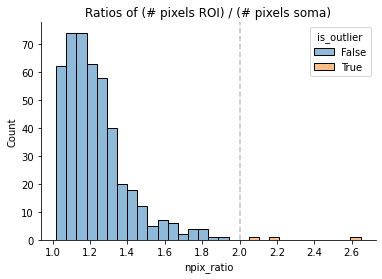

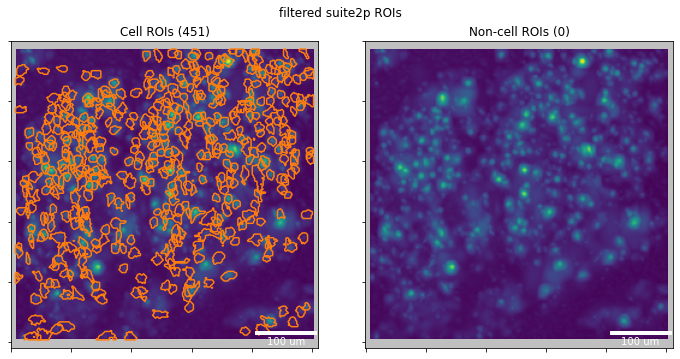

In [26]:
from constants import NPIX_RATIO_THR

# Plot npix ratio and identify outlier ROIs
logger.info('identifying outliers based on # pixels ratio...')
figs['npix_ratio'], df_outliers = plot_npix_ratio_distribution(
    cell_s2p_data['stat'], thr=NPIX_RATIO_THR)
df_outliers[Label.ROI] = icells
df_outliers = df_outliers.set_index(Label.ROI)
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = cell_Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
s2p_data = filter_s2p_data(cell_s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

 13/12/2021 17:28:43: plotting F_ROI (a.u.) traces of all ROIs...


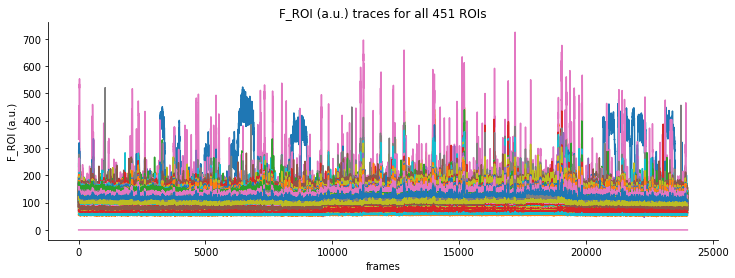

In [27]:
# Plot raw fluorescence traces for all ROIs 
figs['F_ROI_traces_allROIs'] = plot_all_ROIs(Ftimeseries, Label.F_ROI)

### Discard ROIs with zero absolute fluorescence (invalid)

 13/12/2021 17:28:48: updating dataset...
 13/12/2021 17:28:49: filtered to 450 ROIs x 15 runs x 16 trials x 100 frames fluorescence timeseries dataframe
 13/12/2021 17:28:49: plotting suite2p identified ROIs...
 13/12/2021 17:28:51: identified 1 invalid ROI(s):


max F_ROI (a.u.)  is_invalid
ROI                              
588               0.0        True

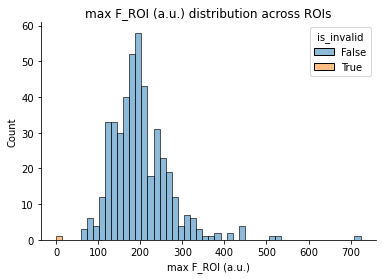

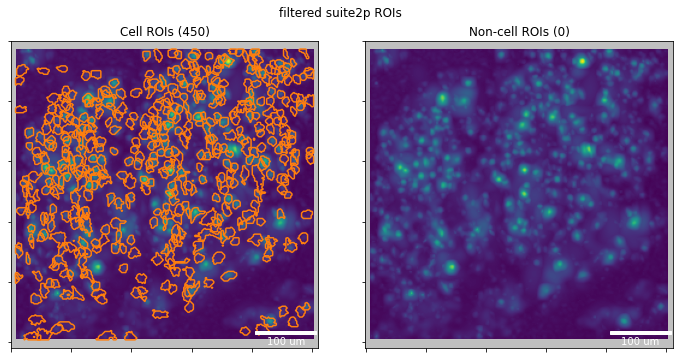

In [28]:
# Extract max F_ROI value of each ROI across time
F_ROI_max = Ftimeseries[Label.F_ROI].groupby(Label.ROI).max().rename(Label.MAX_F_ROI)

F_NEU_max = Ftimeseries[Label.F_NEU].groupby(Label.ROI).max().rename('tmp')
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])


# Identify invalid ROIs with zero F_ROI range 
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Plot histogram distribution of max F_ROI across ROIs
fig, ax = plt.subplots()
ax.set_title(f'max {Label.F_ROI} distribution across ROIs')
sns.despine(ax=ax)
sns.histplot(df_invalids, x=Label.MAX_F_ROI, hue='is_invalid', bins=50, ax=ax)

# Discard invalid ROIs from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_invalids['is_invalid'])
Ftimeseries = Ftimeseries.loc[(df_invalids.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

# Log identified invalids
logger.info(f'identified {len(iinvalids)} invalid ROI(s):')
df_invalids.iloc[iinvalids]

### Select subset of ROIs and runs to plot

 13/12/2021 17:28:51: randomly selecting 3 ROI(s) for plotting (index(es) = [202 302 537])
 13/12/2021 17:28:51: selecting run 11 with parameters P = 0.80 MPa and DC = 5000 % for plotting
 13/12/2021 17:28:51: sub-indexing data...
 13/12/2021 17:28:52: filtering data...
 13/12/2021 17:28:52: cross-checking filters...
 13/12/2021 17:28:52: plotting 2 fluorescence trace(s)...
 13/12/2021 17:28:52: adding 16 delimiters


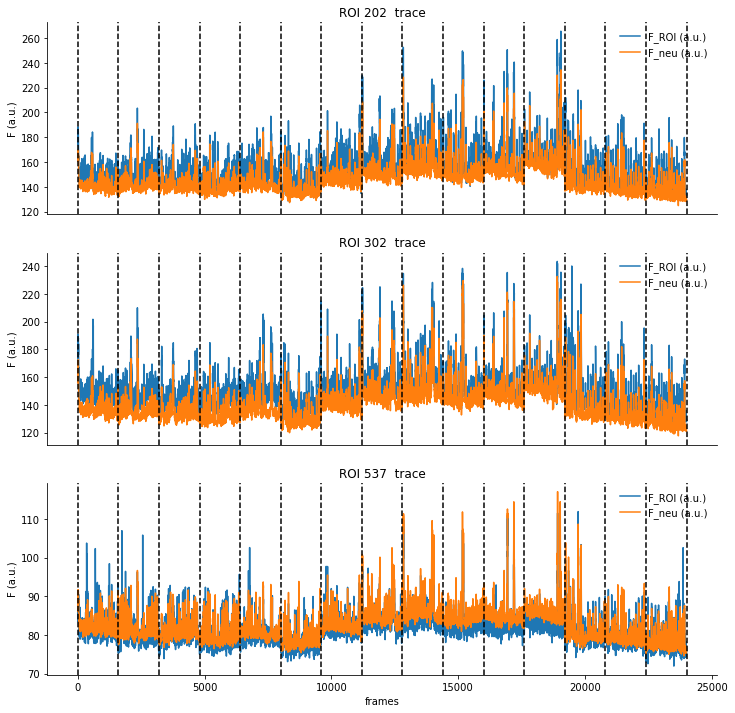

In [29]:
# Select subset of ROIs
iROIs = Ftimeseries.index.unique(level=Label.ROI)
iROI_plt = np.random.choice(iROIs, size=3)
iROI_plt.sort()  # sort ROIs subset to ensure consistent looping
logger.info(f'randomly selecting {len(iROI_plt)} ROI(s) for plotting (index(es) = {iROI_plt})')

# Find run with high P and DC to plot
irun_plt = output_info_table[
    (output_info_table[Label.P] == P_REF) & (output_info_table[Label.DC] == DC_REF)
    ].index[0]
logger.info(f'selecting run {irun_plt} with parameters P = {P_REF:.2f} MPa and DC = {DC_REF * 1e2:.0f} % for plotting')

# Plot longitudinal fluorescence traces for selected ROI
figs['raw_F_traces'] = plot_traces(
    Ftimeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
    iROI=iROI_plt, delimiters=run_delimiters)

### Plot linear fits between ROI and neuropil fluorescence profiles

 13/12/2021 18:55:31: plotting F_ROI = f(F_NEU) with linear regression for ROI 202...
 13/12/2021 18:55:31: optimal fit: F_ROI = 1.16 * F_NEU + -15.62
 13/12/2021 18:55:31: plotting F_ROI = f(F_NEU) with linear regression for ROI 302...
 13/12/2021 18:55:31: optimal fit: F_ROI = 0.99 * F_NEU + 11.74
 13/12/2021 18:55:31: plotting F_ROI = f(F_NEU) with linear regression for ROI 537...
 13/12/2021 18:55:32: optimal fit: F_ROI = 0.82 * F_NEU + 14.08


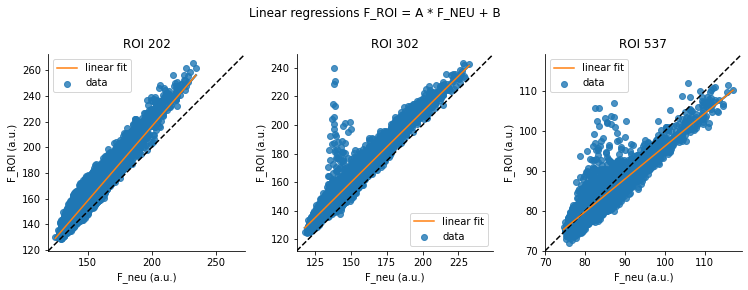

In [116]:
fig = plot_linreg(Ftimeseries, iROI_plt)

### Compute neuropil-corrected fluorescence data

 13/12/2021 18:24:22: computing alphas minimizing costfunc within (0.2, 2) interval...


450it [00:10, 43.25it/s]                         


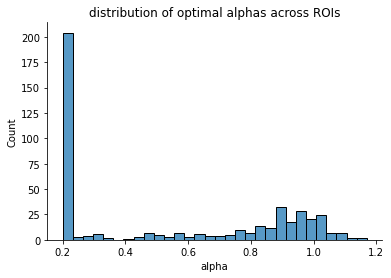

In [100]:
# Compute ROI-specific neuropil coefficients minimizing specific cost function
nROIs = len(Ftimeseries.index.unique(Label.ROI))
alpha_bounds = (0.2, 2)
logger.info(f'computing alphas minimizing {costfunc.__name__} within {alpha_bounds} interval...')
with tqdm(total=nROIs - 1, position=0, leave=True) as pbar:
    alphas = Ftimeseries.groupby(Label.ROI).apply(
        pbar_update(lambda x: optimize_alpha(x, costfunc, bounds=alpha_bounds), pbar))
alphas = alphas.rename(Label.ALPHA).to_frame()

# Plot resulting distribution of neuropil subtraction coefficients
figs['alphas'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('distribution of optimal alphas across ROIs')
sns.histplot(alphas, x=Label.ALPHA, ax=ax, bins=30)

# Expand alphas along necessary dimensions and add it to timeseries dataframe
Ftimeseries[Label.ALPHA] = repeat_along_new_dims(
    alphas, 
    {k : Ftimeseries.index.unique(level=k) for k in [Label.RUN, Label.TRIAL, Label.FRAME]})

 13/12/2021 13:11:58: subtracting neuropil background...
 13/12/2021 13:11:58: sub-indexing data...
 13/12/2021 13:11:58: filtering data...
 13/12/2021 13:11:58: cross-checking filters...
 13/12/2021 13:11:58: plotting 1 fluorescence trace(s)...
 13/12/2021 13:11:58: adding 16 delimiters


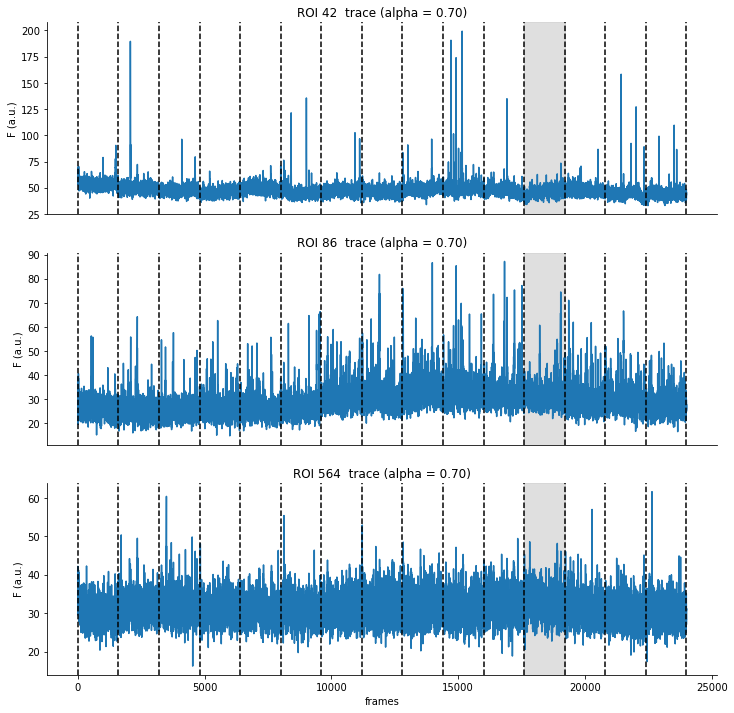

In [29]:
# Subtract neuropil background fluorescence for each ROI of interest
logger.info(f'subtracting neuropil background...')
Ftimeseries[Label.F] = Ftimeseries[Label.F_ROI] - Ftimeseries[Label.ALPHA] * Ftimeseries[Label.F_NEU]

# Plot longitudinal fluorescence traces for selected ROI
alphas_plt = Ftimeseries.loc[iROI_plt, Label.ALPHA].groupby(Label.ROI).first()
figs['F_trace'] = plot_traces(
    Ftimeseries[[Label.F]],
    iROI=iROI_plt, delimiters=run_delimiters,
    title=[f'{Label.ALPHA} = {x:.2f}' for x in alphas_plt])
# Highlight selected run on figure
for ax in figs['F_trace'].axes:
    ax.axvspan(run_delimiters[irun_plt], run_delimiters[irun_plt + 1], color='silver', alpha=0.5)

 13/12/2021 13:11:58: plotting F (a.u.) traces of all ROIs...


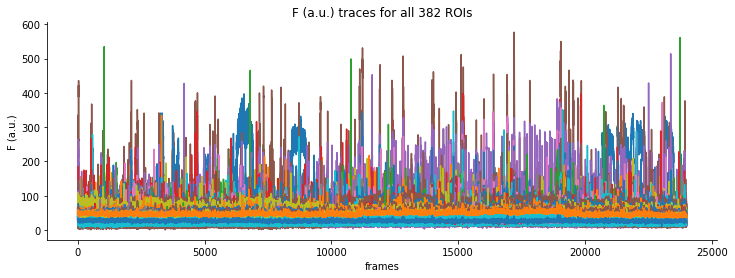

In [30]:
# Plot corrected fluorescence for all ROIs
figs['F_traces_allROIs'] = plot_all_ROIs(Ftimeseries, Label.F)

### Plot fluorescence timecourse for specific run

 13/12/2021 13:12:03: sub-indexing data...
 13/12/2021 13:12:03: filtering data...
 13/12/2021 13:12:03: cross-checking filters...
 13/12/2021 13:12:03: plotting 1 fluorescence trace(s)...
 13/12/2021 13:12:03: adding 16 delimiters


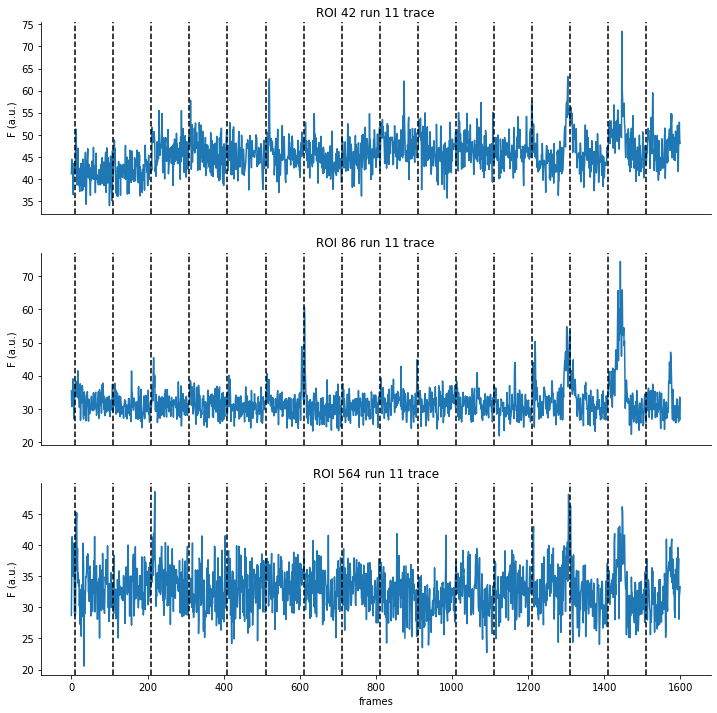

In [31]:
# Plot fluorescence timecourse of selected ROI for selected run
figs[f'F_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.F]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)

### Compute time-varying fluorescence baseline

To do so, we apply a low percentile sliding window over the entire fluorescence timecourse.

This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

 13/12/2021 13:12:03: computing signal baseline as successive application of:
  - 5th percentile of 15.0s (53 frames) sliding window
  - mean of 7.6s (27 frames) sliding window


5730it [00:09, 603.59it/s]                          


 13/12/2021 13:12:13: sub-indexing data...
 13/12/2021 13:12:13: filtering data...
 13/12/2021 13:12:13: cross-checking filters...
 13/12/2021 13:12:13: ambiguous y-labeling for more than 1 signal
 13/12/2021 13:12:13: plotting 2 fluorescence trace(s)...
 13/12/2021 13:12:13: adding 16 delimiters


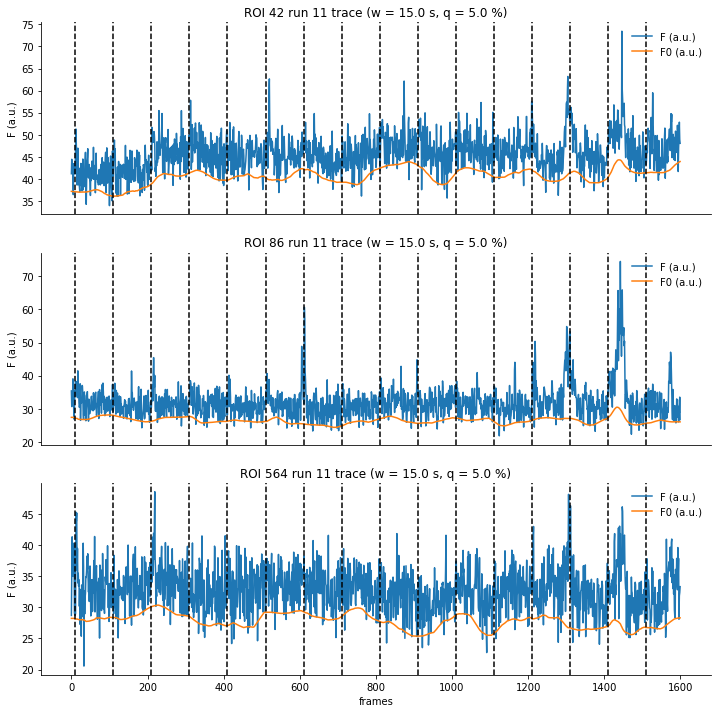

In [32]:
from constants import BASELINE_WLEN, BASELINE_QUANTILE
Ftimeseries[Label.F0] = compute_baseline(
    Ftimeseries[Label.F], fps, BASELINE_WLEN, BASELINE_QUANTILE)

# Plot original and baseline fluorescence of selected ROI for selected run
figs[f'F_F0_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.F, Label.F0]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters,
    title=f'w = {BASELINE_WLEN:.1f} s, q = {BASELINE_QUANTILE * 1e2:.1f} %')

### Remove outliers with fluctuating baseline

For downstream analysis steps, we wish to consider only cells who exhibiit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

 13/12/2021 13:12:14: computing baseline relative standard deviation...
 13/12/2021 13:12:15: identifying outliers...
 13/12/2021 13:12:15: updating dataset...
 13/12/2021 13:12:16: filtered to 381 ROIs x 15 runs x 16 trials x 100 frames fluorescence dataframe
 13/12/2021 13:12:16: identified 1 outlier(s):


max F0 RSD  is_outlier
ROI                        
0       0.92638        True

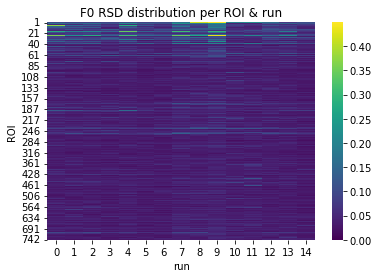

In [33]:
from constants import BASELINE_RSD_THR

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).agg(
    lambda x: np.std(x) / np.abs(x.mean()))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(Label.ROI).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
ax = sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0, cmap='viridis')
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence dataframe')

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### Apply baseline correction

Downstream analysis steps require fluorescence signals with a relatively flat activity baseline. Therefore, fluorescence signals are corrected by subtraction of a mean-corrected time-varying baseline.

 13/12/2021 13:12:16: subtracting mean-corrected baseline from signals...
 13/12/2021 13:12:26: sub-indexing data...
 13/12/2021 13:12:26: filtering data...
 13/12/2021 13:12:26: cross-checking filters...
 13/12/2021 13:12:26: ambiguous y-labeling for more than 1 signal
 13/12/2021 13:12:26: plotting 2 fluorescence trace(s)...
 13/12/2021 13:12:26: adding 16 delimiters


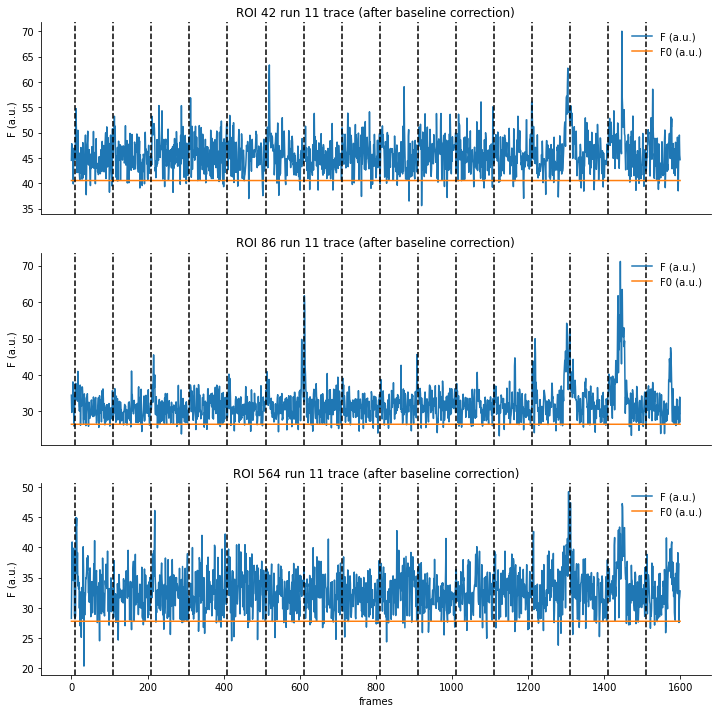

In [34]:
logger.info('subtracting mean-corrected baseline from signals...')
# Compute mean baseline value per ROI & run
F0_mean = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
# Apply baseline corretor to both fluorescence and baseline signals
baseline_corrector = Ftimeseries[Label.F0] - F0_mean
Ftimeseries[Label.F] -= baseline_corrector
Ftimeseries[Label.F0] -= baseline_corrector

# Plot baseline-corrected fluorescence signal and baseline of selected ROI for selected run
figs[f'F_F0_trace_run{irun_plt}_corrected'] = plot_traces(
    Ftimeseries[[Label.F, Label.F0]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters,
    title='after baseline correction')

### Remove first trials of each condition

<span style="color:red">NOTE: on the acquisition side, nothing is wrong with the first trial of each condition. However, since the different runs were fed together into suite2p (in order to improve ROI identification), the resulting fluorescence timecourses for each ROI were computed by suite2p under the assumption of time continuity, which is NOT the case during run-to-run transitions. We therefore discard the first trial of each run, since the fluorescence data is physiologically invalid around these transitions.</span>

In [35]:
# Discard first trial of each run (if not done already)
from constants import ITRIALS_DISCARD
Ftimeseries = remove_trials(Ftimeseries, iremove=ITRIALS_DISCARD)
logger.info(f'filtered data ({describe_dataframe_index(Ftimeseries)})')

 13/12/2021 13:12:27: removing trials [0] for each run...
 13/12/2021 13:12:28: filtered data (381 ROIs x 15 runs x 15 trials x 100 frames)


### Compute relative fluorescence change

 13/12/2021 13:12:28: computing relative change in fluorescence...
 13/12/2021 13:12:41: sub-indexing data...
 13/12/2021 13:12:41: filtering data...
 13/12/2021 13:12:41: cross-checking filters...
 13/12/2021 13:12:41: plotting 1 fluorescence trace(s)...
 13/12/2021 13:12:41: adding 16 delimiters


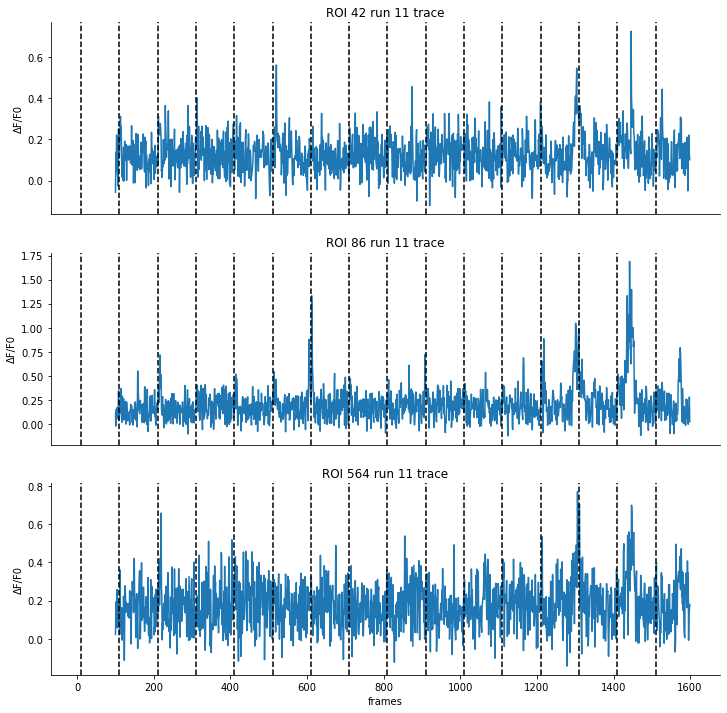

In [36]:
# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
F0 = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).median()  # median of the baseline over each run
Ftimeseries[Label.DFF] = (Ftimeseries[Label.F] - F0) / F0

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
figs[f'dFF_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.DFF]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)

### Fit gaussians to dFF histogram distributions

 13/12/2021 13:12:42: fitting gaussians to dFF histogram distributions...


5715it [00:33, 169.65it/s]                          

 13/12/2021 13:13:15: extracting fitted gaussian parameters...


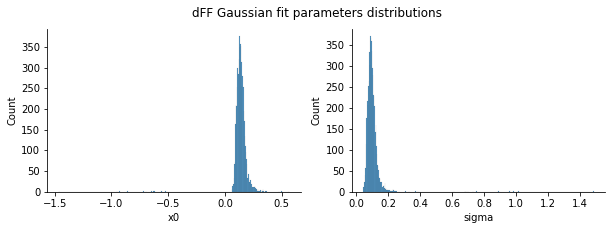

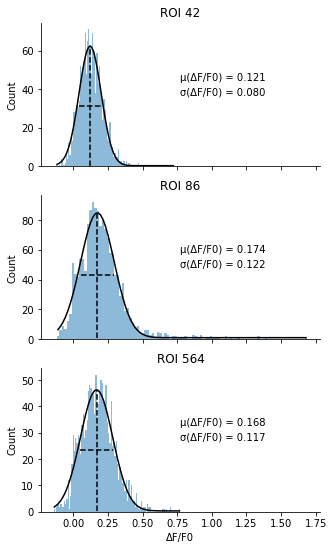

In [37]:
# Fit gaussians to dFF histogram distributions
logger.info('fitting gaussians to dFF histogram distributions...')
nROIs, nruns = [len(Ftimeseries.index.unique(k)) for k in [Label.ROI, Label.RUN]]
with tqdm(total=nROIs * nruns - 1, position=0, leave=True) as pbar:
    dFF_histfits = Ftimeseries[Label.DFF].groupby([Label.ROI, Label.RUN]).agg(
        pbar_update(gauss_histogram_fit, pbar))
nbins = dFF_histfits.iloc[0][0].size
logger.info('extracting fitted gaussian parameters...')
dFF_histparams = dFF_histfits.apply(lambda x: x[1])
dFF_histparams = pd.DataFrame(
    dFF_histparams.tolist(),
    columns=['H', 'A', 'x0', 'sigma'],
    index=dFF_histparams.index)

# Plot histogram distributions of the relevant extracted Gaussian parameters
mkeys = ['x0', 'sigma']
figs['gaussianfits_dists'], axes = plt.subplots(1, len(mkeys), figsize=(5 * len(mkeys), 3))
figs['gaussianfits_dists'].suptitle('dFF Gaussian fit parameters distributions')
for ax, mk in zip(axes, mkeys):
    sns.despine(ax=ax)
    sns.histplot(dFF_histparams, x=mk, ax=ax)

# Plot dFF histogram distribution and fitted gaussian parameters for each ROI of interest 
figs[f'dFF_hist_fits_run{irun_plt}'] = plot_gaussian_histogram_fit(
    Ftimeseries, dFF_histparams, iROI_plt, irun_plt, nbins=nbins)

### Compute dFF z-score traces

 13/12/2021 13:13:17: normalizing dFF by gaussian parameters to compute z-scores...
 13/12/2021 13:13:31: sub-indexing data...
 13/12/2021 13:13:31: filtering data...
 13/12/2021 13:13:31: cross-checking filters...
 13/12/2021 13:13:31: plotting 1 fluorescence trace(s)...
 13/12/2021 13:13:31: adding 16 delimiters


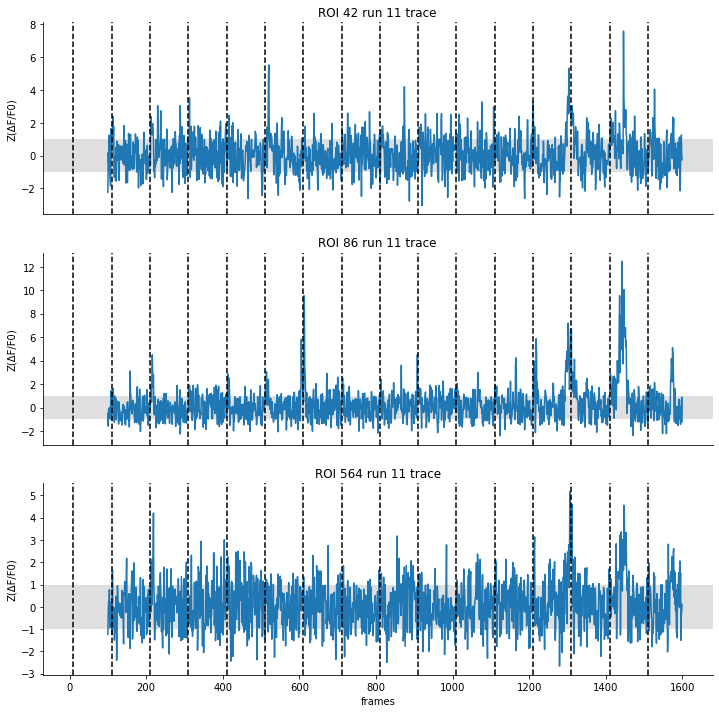

In [38]:
# Normalize dFF traces by gaussian parameters to obtain dFF z-scores
logger.info('normalizing dFF by gaussian parameters to compute z-scores...')
Ftimeseries[Label.ZSCORE] = (Ftimeseries.loc[:, Label.DFF] - dFF_histparams['x0']) / dFF_histparams['sigma']

# Plot consecutive trials of dFF z-score of selected ROI for selected run
figs[f'zscore_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.ZSCORE]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)
# Plot estimated noise range on the z-score trace
for ax in figs[f'zscore_trace_run{irun_plt}'].axes:
    ax.axhspan(- 1, 1, fc='silver', ec=None, alpha=0.5);

### Create statistics dataframe

In [39]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: Ftimeseries.index.unique(k) for k in Ftimeseries.index.names}

# Create Fstats dataframes
logger.info('creating statistics dataframe')
Fstats = pd.DataFrame()

 13/12/2021 13:13:32: creating statistics dataframe


### Identify trials with pre-stimulus activity

 13/12/2021 13:13:32: analyzing fluorescence activity in pre-stimulus intervals...
 13/12/2021 13:13:32: identified 17655 trials over 85725 (20.6 %) with significant pre-stimulus activity (Z(ΔF/F0) > 1.645)
 13/12/2021 13:13:33: sub-indexing data...
 13/12/2021 13:13:33: filtering data...
 13/12/2021 13:13:33: cross-checking filters...
 13/12/2021 13:13:33: plotting 1 fluorescence trace(s)...
 13/12/2021 13:13:33: adding 16 delimiters


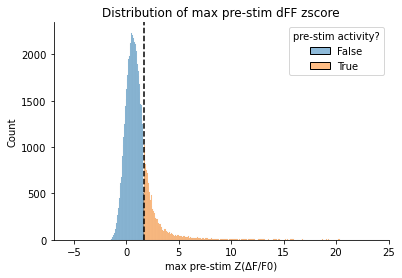

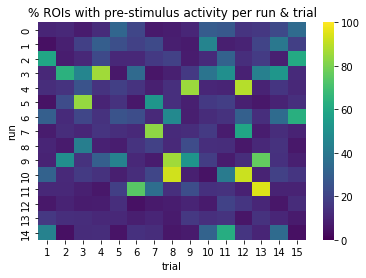

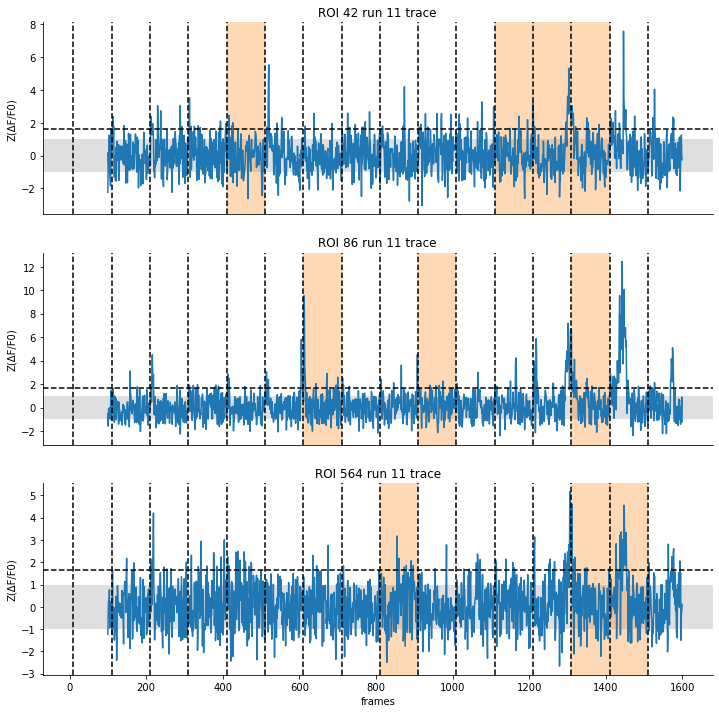

In [40]:
from constants import ZSCORE_PRESTIM_THR

logger.info('analyzing fluorescence activity in pre-stimulus intervals...')
# Identify max dFF z-score in pre-stimulus window for each trial
zscore_prestim = Ftimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.ZSCORE]
Fstats[Label.MAX_ZSCORE_PRESTIM] = zscore_prestim.groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).max()

# Classify pre-stimulus state based on this metrics
Fstats[Label.PRESTIM_ACTIVITY] = Fstats[Label.MAX_ZSCORE_PRESTIM] > ZSCORE_PRESTIM_THR
nacts, ntot = Fstats[Label.PRESTIM_ACTIVITY].sum(), len(Fstats)
logger.info(f'identified {nacts} trials over {ntot} ({nacts / ntot * 1e2:.1f} %) with significant pre-stimulus activity ({Label.ZSCORE} > {ZSCORE_PRESTIM_THR})')

# Plot histogram distribution of pre-stimulus dFF z-score
figs['prestim_zscore_level_dist'], ax = plt.subplots()
sns.despine(ax=ax)
ax = sns.histplot(Fstats, x=Label.MAX_ZSCORE_PRESTIM, hue=Label.PRESTIM_ACTIVITY, ax=ax)
ax.axvline(ZSCORE_PRESTIM_THR, ls='--', c='k')
ax.set_xlim(ax.get_xlim()[0], 25)
ax.set_title('Distribution of max pre-stim dFF zscore')

# Plot number of ROIs with pre-stimulus activity for each run & trial (to see if there is a trend)
nROIs = len(Fstats.index.unique(level=Label.ROI))
pct_prestim_per_run_trial = Fstats.loc[:, Label.PRESTIM_ACTIVITY].groupby(
    [Label.RUN, Label.TRIAL]).sum() / nROIs * 1e2
figs['pct_prestim_activity_map'], ax = plt.subplots()
sns.heatmap(pct_prestim_per_run_trial.unstack(), ax=ax, cmap='viridis', vmin=0, vmax=100)
ax.set_title('% ROIs with pre-stimulus activity per run & trial')

# Plot consecutive trials of dFF z-score of selected ROI for selected run 
figs[f'zscore_trace_run{irun_plt}_labeled'] = plot_traces(
    Ftimeseries[[Label.ZSCORE]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)
for ir, ax in zip(iROI_plt, figs[f'zscore_trace_run{irun_plt}_labeled'].axes):
    # Plot estimated noise range on the z-score traces
    ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
    # Plot pre-stimulus activity threshold and label trials with pre-stim activity
    ax.axhline(ZSCORE_PRESTIM_THR, ls='--', c='k');
    mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_plt)

### Compute relative z-score change w.r.t. pre-stim value for each trial

In [41]:
# Extract pre-stimulus z-score level
logger.info('extracting mean z-score pre-stim level for each trial...')
z_onset = zscore_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).mean()

# Subtract pre-stim z-score value to get relative z-score
logger.info('computing relative z-scores changes (w.r.t. pre-stim level) for each trial...')
Ftimeseries[Label.REL_ZSCORE] = (Ftimeseries.loc[:, Label.ZSCORE] - z_onset)

 13/12/2021 13:13:36: extracting mean z-score pre-stim level for each trial...
 13/12/2021 13:13:36: computing relative z-scores changes (w.r.t. pre-stim level) for each trial...


### Compute stimlulus-evoked peak z-score w.r.t. pre-stim value

 13/12/2021 13:13:46: identifying peak relative z-score in response window...
 13/12/2021 13:13:50: identified 85684 response peaks over 85725 trials (success rate = 100.0 %)
 13/12/2021 13:13:52: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - all trials...
 13/12/2021 13:13:52: computing new index according to hierarchical clustering...
 13/12/2021 13:13:52: re-arranging dataset...
 13/12/2021 13:13:53: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - False trials...
 13/12/2021 13:13:53: computing new index according to hierarchical clustering...
 13/12/2021 13:13:53: re-arranging dataset...
 13/12/2021 13:13:53: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - True trials...
 13/12/2021 13:13:53: computing new index according to hierarchical clustering...
 13/12/2021 13:13:53: cannot clusterize dataset with NaNs -> ignoring
 13/12/2021 13:13:53: re-arranging dataset...


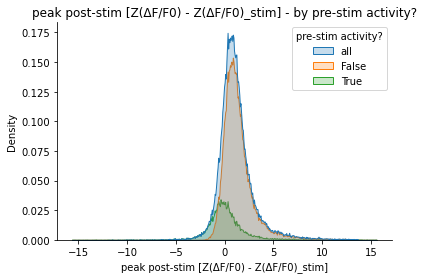

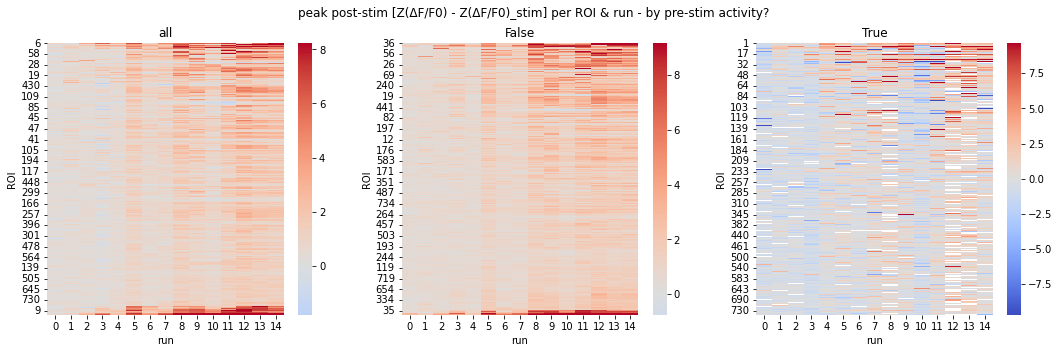

In [42]:
# Identify peak z-score in analysis window
logger.info('identifying peak relative z-score in response window...')
relz_window = Ftimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.RESPONSE], Label.REL_ZSCORE]
Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] = relz_window.groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).agg(find_response_peak)
npeaks, ntrials = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM].notna().sum(), len(Fstats)
logger.info(f'identified {npeaks} response peaks over {ntrials} trials (success rate = {npeaks / ntrials * 1e2:.1f} %)')

# Plot peak z-score histogram
figs[f'peak_rel_zscore_hist'] = plot_stat_histogram(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM, groupby=Label.PRESTIM_ACTIVITY, nstd=5)

# Plot average peak z-score per ROI & run
figs[f'peak_rel_zscore_map'] = plot_stat_heatmap(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM, cmap='coolwarm',
    groupby=Label.PRESTIM_ACTIVITY, nstd=5, cluster=True)

### Identify stimulus-evoked responses

 13/12/2021 13:13:53: identifying stimulus-evoked responses...
 13/12/2021 13:13:54: sub-indexing data...
 13/12/2021 13:13:54: filtering data...
 13/12/2021 13:13:54: cross-checking filters...
 13/12/2021 13:13:54: plotting 1 fluorescence trace(s)...
 13/12/2021 13:13:54: adding 16 delimiters


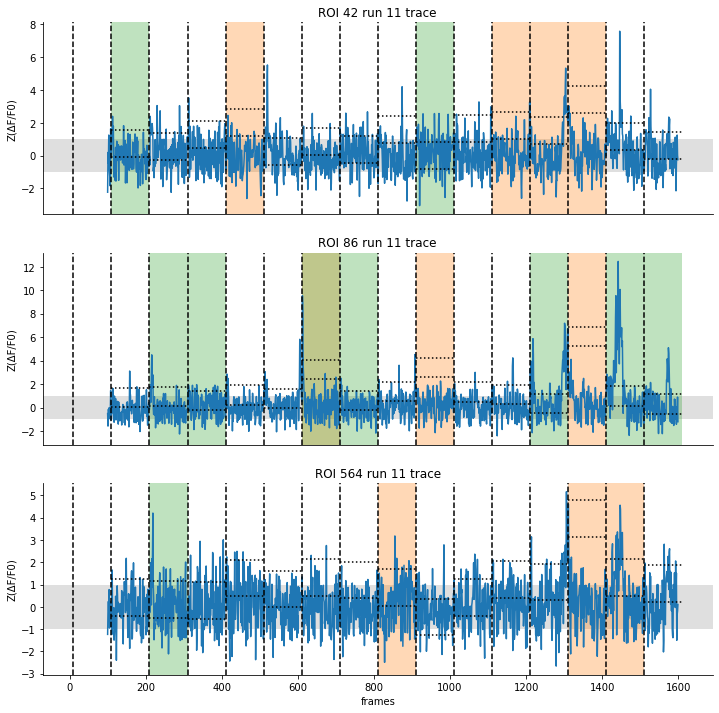

In [43]:
logger.info('identifying stimulus-evoked responses...')
# Identify "proper" responses as those with a z-score above defined threshold 
Fstats[Label.IS_RESP] = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] > REL_ZSCORE_RESPONSE_THR

# Plot consecutive trials of relative z-score of selected ROI for selected run
figs[f'zscore_trace_run{irun_plt}_labeled2'] = plot_traces(
    Ftimeseries[[Label.ZSCORE]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)
# Label trials with pre-stim activity and those with post-stimlus response
for (ir, ax) in zip(iROI_plt, figs[f'zscore_trace_run{irun_plt}_labeled2'].axes):
    # Plot estimated noise range on the z-score traces
    ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
    # Plot pre-stim level and post-stim detection threshold for each trial
    z0 = z_onset.loc[ir, irun_plt]
    istart, z0 = z0.index.values, z0.values
    xstart = stim_delimiters[istart]
    for zoffset, ls in zip([0., REL_ZSCORE_RESPONSE_THR], [':', ':']): 
        ax.hlines(
            z0 + zoffset, xstart, xstart + NFRAMES_PER_TRIAL,
            colors='k', linestyles=ls, zorder=3)
    # Label trials with pre-stim activity and those with post-stim response
    mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_plt)
    mark_trials(ax, Fstats[Label.IS_RESP], ir, irun_plt, color='C2')

### Inspect response success rate

 13/12/2021 13:13:56: plotting trial-averaged success rate per ROI & run - all trials...
 13/12/2021 13:13:56: computing new index according to hierarchical clustering...
 13/12/2021 13:13:56: re-arranging dataset...
 13/12/2021 13:13:56: plotting trial-averaged success rate per ROI & run - False trials...
 13/12/2021 13:13:56: computing new index according to hierarchical clustering...
 13/12/2021 13:13:56: re-arranging dataset...
 13/12/2021 13:13:57: plotting trial-averaged success rate per ROI & run - True trials...
 13/12/2021 13:13:57: computing new index according to hierarchical clustering...
 13/12/2021 13:13:57: cannot clusterize dataset with NaNs -> ignoring
 13/12/2021 13:13:57: re-arranging dataset...
 13/12/2021 13:13:58: plotting trial-averaged success rate - all trials...
 13/12/2021 13:13:58: plotting trial-averaged success rate - False trials...
 13/12/2021 13:13:58: plotting trial-averaged success rate - True trials...


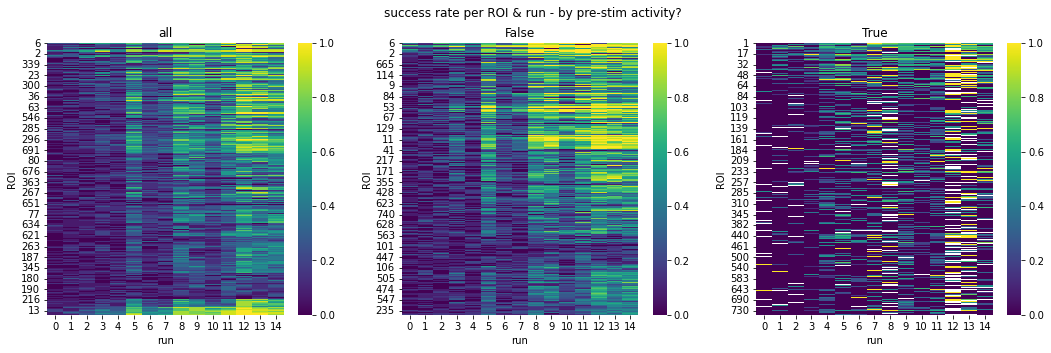

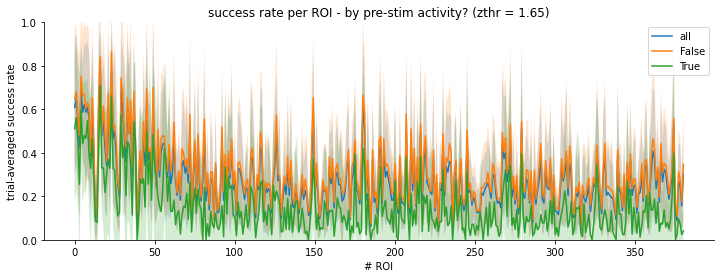

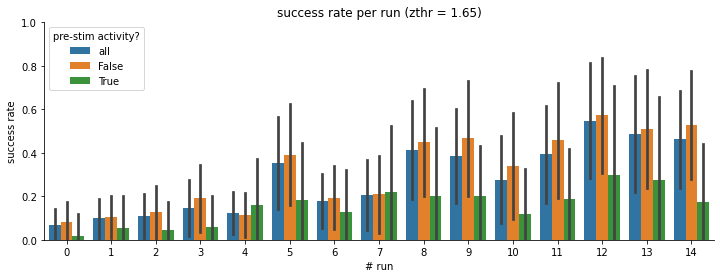

In [44]:
# Plot success rate per ROI & run
groupby = Label.PRESTIM_ACTIVITY
figs[f'sr_map'] = plot_stat_heatmap(
    Fstats, Label.IS_RESP, cmap='viridis', groupby=groupby, cluster=True)
# Plot success rate per ROI
figs['sr_per_ROI'] = plot_stat_per_ROI(
    Fstats, Label.IS_RESP,
    title=f'zthr = {REL_ZSCORE_RESPONSE_THR:.2f}', groupby=groupby)
# Plot success rate per run
figs['sr_per_run'] = plot_stat_per_run(
    Fstats, Label.IS_RESP,
    title=f'zthr = {REL_ZSCORE_RESPONSE_THR:.2f}', groupby=groupby)

### Compute corrected (response-only) z-scores

 13/12/2021 13:14:01: computing corrected z-scores (discarding no-response trials)...
 13/12/2021 13:14:24: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) per ROI & run - all trials...
 13/12/2021 13:14:24: computing new index according to hierarchical clustering...
 13/12/2021 13:14:24: cannot clusterize dataset with NaNs -> ignoring
 13/12/2021 13:14:24: re-arranging dataset...
 13/12/2021 13:14:24: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) per ROI & run - False trials...
 13/12/2021 13:14:24: computing new index according to hierarchical clustering...
 13/12/2021 13:14:24: cannot clusterize dataset with NaNs -> ignoring
 13/12/2021 13:14:24: re-arranging dataset...
 13/12/2021 13:14:24: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) per ROI & run - True trials...
 13/12/2021 13:14:24: computing new index according to hierarchical clustering...
 13/12/2021 13:14:24: cannot

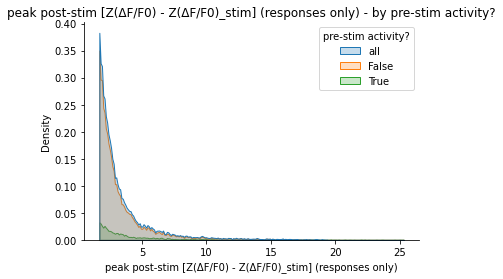

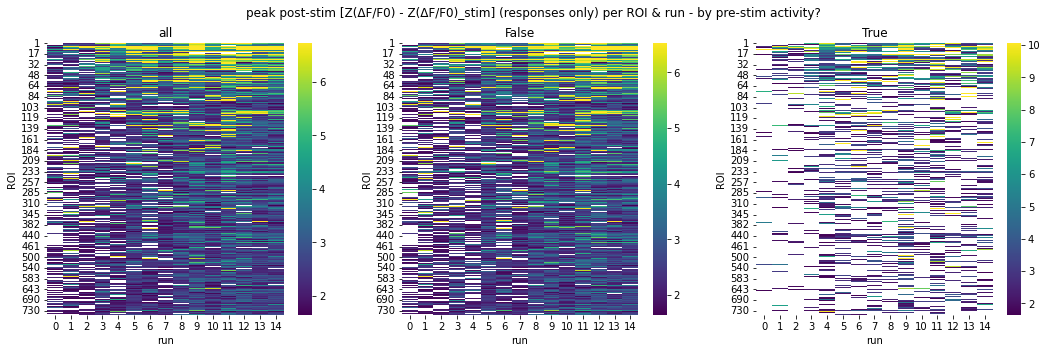

In [45]:
logger.info('computing corrected z-scores (discarding no-response trials)...')
# Extract z-scores from timeseries and stats tables
Ftimeseries[Label.REL_ZSCORE_RESPONLY] = Ftimeseries[Label.REL_ZSCORE]
Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY] = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM]
# Set no-response trials to NaN
noresp = ~Fstats[Label.IS_RESP]
Ftimeseries.loc[noresp, Label.REL_ZSCORE_RESPONLY] = np.nan
Fstats.loc[noresp, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY] = np.nan

# Plot corrected peak z-score histogram
figs[f'corrected_peak_rel_zscore_hist'] = plot_stat_histogram(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY, groupby=Label.PRESTIM_ACTIVITY, nstd=5)

# Plot corrected peak z-score per ROI & run
figs['corrected_peak_zscore_map'] = plot_stat_heatmap(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY, cmap='viridis',
    groupby=Label.PRESTIM_ACTIVITY, nstd=2, cluster=True)

### Classify response type per ROI

 13/12/2021 13:14:25: identifying "positive" runs for each ROI...
 13/12/2021 13:14:25: computing number of "positive" runs for each ROI...
 13/12/2021 13:14:25: classifying ROI response types...


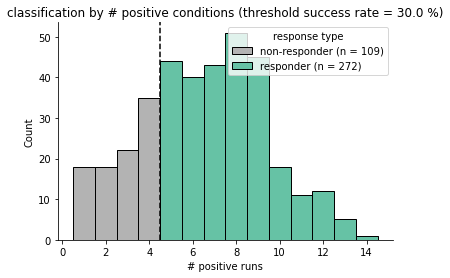

In [46]:
logger.info('identifying "positive" runs for each ROI...')
# Compute success rate over trials with no pre-stimulus activity
is_resp_noprestim = Fstats.loc[~Fstats[Label.PRESTIM_ACTIVITY], Label.IS_RESP]
sr = get_trial_averaged(is_resp_noprestim)
# Identify as "positive" runs those who are above a given success rate (for each ROI)
is_positive_run = sr > SUCCESS_RATE_THR

# Repeat along trial dimension in Fstats table
Fstats[Label.IS_POSITIVE_RUN] = repeat_along_new_dim(
    is_positive_run.to_frame(), 
    Label.TRIAL, index_dims[Label.TRIAL])

# Compute number of "positive" runs for each ROI
logger.info('computing number of "positive" runs for each ROI...')
n_positive_runs = is_positive_run.groupby(Label.ROI).sum().rename(Label.NPOS_RUNS)
# Repeat along run & trial dimensions in Fstats table
Fstats[Label.NPOS_RUNS] = repeat_along_new_dims(
    n_positive_runs.to_frame(), 
    {k: index_dims[k] for k in [Label.RUN, Label.TRIAL]})

# Assign response type to each ROI based on number of positive conditions
logger.info('classifying ROI response types...')
resp_types = (n_positive_runs >= NPOS_CONDS_THR).astype(int).rename(Label.ROI_RESP_TYPE)
resp_types = resp_types.map(LABEL_BY_TYPE)

# Repeat along run & trial dimensions in Fstats table
Fstats[Label.ROI_RESP_TYPE] = repeat_along_new_dims(
    resp_types.to_frame(), 
    {k: index_dims[k] for k in [Label.RUN, Label.TRIAL]})

# Plot the histogram of the number of positive conditions per response type
nruns = len(is_positive_run.index.unique(level=Label.RUN))
figs[Label.NPOS_RUNS] = plot_positive_runs_hist(
    n_positive_runs, resp_types, nruns,
    title=f'threshold success rate = {SUCCESS_RATE_THR * 1e2} %')

### Print Fstats table

In [47]:
logger.info('Fstats table:')
Fstats

 13/12/2021 13:14:25: Fstats table:


max pre-stim Z(ΔF/F0)  pre-stim activity?  \
ROI run trial                                              
1   0   1                   0.289432               False   
        2                   1.258643               False   
        3                  -0.456189               False   
        4                   1.810008                True   
        5                  -0.284421               False   
...                              ...                 ...   
742 14  11                  1.040807               False   
        12                  1.915790                True   
        13                  0.475534               False   
        14                  0.530714               False   
        15                  0.242459               False   

               peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]  trial response?  \
ROI run trial                                                               
1   0   1                                       0.385877            False   
        2                                       0.631629            False   
        3                                       1.395185            False   
        4                                       0.166279            False   
        5                                       0.581579            False   
...                                                  ...              ...   
742 14  11                                      0.338301            False   
        12                                      0.252443            False   
        13                                      1.701678             True   
        14                                      1.113874            False   
        15                                      3.710349             True   

               peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only)  \
ROI run trial                                                               
1   0   1                                                    NaN            
        2                                                    NaN            
        3                                                    NaN            
        4                                                    NaN            
        5                                                    NaN            
...                                                          ...            
742 14  11                                                   NaN            
        12                                                   NaN            
        13                                              1.701678            
        14                                                   NaN            
        15                                              3.710349            

               positive run?  # positive runs response type  
ROI run trial                                                
1   0   1              False               12     responder  
        2              False               12     responder  
        3              False               12     responder  
        4              False               12     responder  
        5              False               12     responder  
...                      ...              ...           ...  
742 14  11              True                8     responder  
        12              True                8     responder  
        13              True                8     responder  
        14              True                8     responder  
        15              True                8     responder  

[85725 rows x 8 columns]

### Add everything to global data table

<span style="color:yellow">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [48]:
# Expand output table
logger.info('expanding output table along ROI, trial and frame dimensions...')
exp_output_table = output_info_table.copy()
for k in [Label.NPERTRIAL, Label.NTRIALS]:
    del exp_output_table[k]
exp_output_table = repeat_along_new_dims(
    exp_output_table,
    {k: index_dims[k] for k in [Label.ROI, Label.TRIAL, Label.FRAME]})
exp_output_table = exp_output_table.reorder_levels(list(index_dims.keys())).sort_index()
# Expand Fstats
logger.info('expanding Fstats along frame dimension...')
exp_Fstats = repeat_along_new_dim(Fstats, Label.FRAME, index_dims[Label.FRAME])
# Merge datasets
logger.info('merging datasets...')
data = pd.concat([exp_output_table, Ftimeseries, exp_Fstats], axis=1)
# Add time to dataset
data = add_time_to_table(data)
logger.info('data table:')
data

 13/12/2021 13:14:26: expanding output table along ROI, trial and frame dimensions...
 13/12/2021 13:14:32: expanding Fstats along frame dimension...
 13/12/2021 13:14:37: merging datasets...
 13/12/2021 13:14:40: adding time info to table...
 13/12/2021 13:14:45: data table:


time (s)   line  duration (s)  P (MPa)  DC (%)  run ID  \
ROI run trial frame                                                            
1   0   1     0      -2.808989  line3           0.2      0.0    50.0     869   
              1      -2.528090  line3           0.2      0.0    50.0     869   
              2      -2.247191  line3           0.2      0.0    50.0     869   
              3      -1.966292  line3           0.2      0.0    50.0     869   
              4      -1.685393  line3           0.2      0.0    50.0     869   
...                        ...    ...           ...      ...     ...     ...   
742 14  15    95     23.876404  line3           0.2      0.8    80.0     863   
              96     24.157303  line3           0.2      0.8    80.0     863   
              97     24.438202  line3           0.2      0.8    80.0     863   
              98     24.719101  line3           0.2      0.8    80.0     863   
              99     25.000000  line3           0.2      0.8    80.0     863   

                     F_ROI (a.u.)  F_neu (a.u.)  alpha   F (a.u.)  ...  \
ROI run trial frame                                                ...   
1   0   1     0        111.449570    109.706764    0.7  35.496018  ...   
              1        110.854919    111.135338    0.7  33.901366  ...   
              2        114.526161    111.605263    0.7  37.243660  ...   
              3        114.175079    111.712402    0.7  36.817581  ...   
              4        117.339981    112.090225    0.7  39.718007  ...   
...                           ...           ...    ...        ...  ...   
742 14  15    95       128.476852    122.487762    0.7  42.592317  ...   
              96       128.994812    121.496506    0.7  43.796627  ...   
              97       125.516769    120.814682    0.7  40.788332  ...   
              98       127.816483    122.597900    0.7  41.832263  ...   
              99       130.483719    122.767479    0.7  44.375805  ...   

                     Z(ΔF/F0) - Z(ΔF/F0)_stim  \
ROI run trial frame                             
1   0   1     0                     -0.665867   
              1                     -1.193658   
              2                     -0.087439   
              3                     -0.228461   
              4                      0.731510   
...                                       ...   
742 14  15    95                     0.559251   
              96                     0.995648   
              97                    -0.094446   
              98                     0.283836   
              99                     1.205521   

                     Z(ΔF/F0) - Z(ΔF/F0)_stim (responses only)  \
ROI run trial frame                                              
1   0   1     0                                            NaN   
              1                                            NaN   
              2                                            NaN   
              3                                            NaN   
              4                                            NaN   
...                                                        ...   
742 14  15    95                                      0.559251   
              96                                      0.995648   
              97                                     -0.094446   
              98                                      0.283836   
              99                                      1.205521   

                     max pre-stim Z(ΔF/F0)  pre-stim activity?  \
ROI run trial frame                                              
1   0   1     0                   0.289432               False   
              1                   0.289432               False   
              2                   0.289432               False   
              3                   0.289432               False   
              4                   0.289432               False   
...                                    ...                 

### Extract dataframe of trials without pre-stimulus activity

In [49]:
noprestim_data = data.loc[~data[Label.PRESTIM_ACTIVITY], :]
logger.info('data table of trials without pre-stimulus activity:')
noprestim_data

 13/12/2021 13:14:52: data table of trials without pre-stimulus activity:


time (s)   line  duration (s)  P (MPa)  DC (%)  run ID  \
ROI run trial frame                                                            
1   0   1     0      -2.808989  line3           0.2      0.0    50.0     869   
              1      -2.528090  line3           0.2      0.0    50.0     869   
              2      -2.247191  line3           0.2      0.0    50.0     869   
              3      -1.966292  line3           0.2      0.0    50.0     869   
              4      -1.685393  line3           0.2      0.0    50.0     869   
...                        ...    ...           ...      ...     ...     ...   
742 14  15    95     23.876404  line3           0.2      0.8    80.0     863   
              96     24.157303  line3           0.2      0.8    80.0     863   
              97     24.438202  line3           0.2      0.8    80.0     863   
              98     24.719101  line3           0.2      0.8    80.0     863   
              99     25.000000  line3           0.2      0.8    80.0     863   

                     F_ROI (a.u.)  F_neu (a.u.)  alpha   F (a.u.)  ...  \
ROI run trial frame                                                ...   
1   0   1     0        111.449570    109.706764    0.7  35.496018  ...   
              1        110.854919    111.135338    0.7  33.901366  ...   
              2        114.526161    111.605263    0.7  37.243660  ...   
              3        114.175079    111.712402    0.7  36.817581  ...   
              4        117.339981    112.090225    0.7  39.718007  ...   
...                           ...           ...    ...        ...  ...   
742 14  15    95       128.476852    122.487762    0.7  42.592317  ...   
              96       128.994812    121.496506    0.7  43.796627  ...   
              97       125.516769    120.814682    0.7  40.788332  ...   
              98       127.816483    122.597900    0.7  41.832263  ...   
              99       130.483719    122.767479    0.7  44.375805  ...   

                     Z(ΔF/F0) - Z(ΔF/F0)_stim  \
ROI run trial frame                             
1   0   1     0                     -0.665867   
              1                     -1.193658   
              2                     -0.087439   
              3                     -0.228461   
              4                      0.731510   
...                                       ...   
742 14  15    95                     0.559251   
              96                     0.995648   
              97                    -0.094446   
              98                     0.283836   
              99                     1.205521   

                     Z(ΔF/F0) - Z(ΔF/F0)_stim (responses only)  \
ROI run trial frame                                              
1   0   1     0                                            NaN   
              1                                            NaN   
              2                                            NaN   
              3                                            NaN   
              4                                            NaN   
...                                                        ...   
742 14  15    95                                      0.559251   
              96                                      0.995648   
              97                                     -0.094446   
              98                                      0.283836   
              99                                      1.205521   

                     max pre-stim Z(ΔF/F0)  pre-stim activity?  \
ROI run trial frame                                              
1   0   1     0                   0.289432               False   
              1                   0.289432               False   
              2                   0.289432               False   
              3                   0.289432               False   
              4                   0.289432               False   
...                                    ...                 

## Experiments summary results 

### Spatial distribution of cells per response type

 13/12/2021 13:14:57: plotting cells map color-coded by response type...
 13/12/2021 13:14:57: extracting responses types per ROI...


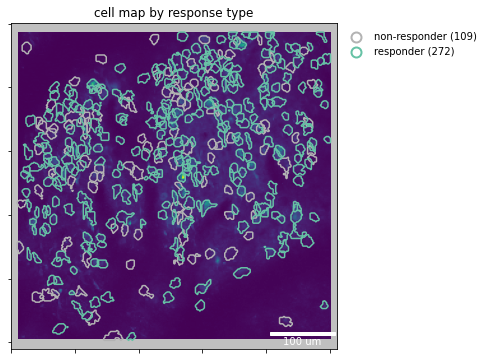

In [50]:
figs['cellmap'] = plot_cell_map(
    data, s2p_data, s2p_ops, title='cell map by response type',
    um_per_px=daq_settings['micronsPerPixel'], refkey='max_proj')

## Response traces

### Plot parameters


In [51]:
tbounds_response = [-2, 8.]  # s
ybounds_response = [-1, 5]
plt_data = noprestim_data

### All traces for single ROI and condition

In [52]:
# iROIs_interactive = data.index.unique(level=Label.ROI)
# view_interactive_plot(
#     lambda i: plot_responses(
#         plt_data, iROI=iROIs_interactive[i], irun=irun_plt,
#         alltraces=True, ykey=Label.ZSCORE, label=Label.SUCCESS_RATE
#         mark_peaks=True, ci=None,
#         tbounds=tbounds_response),
#     len(iROIs_interactive));

### Visualize (ROI, run) combinations with best success rate

 13/12/2021 13:15:00: identified combinations with best success rate:
ROI  run
48   5      1.0
292  9      1.0
136  12     1.0
Name: success rate, dtype: float64
 13/12/2021 13:15:00: sub-indexing data...
 13/12/2021 13:15:00: filtering data...
 13/12/2021 13:15:00: cross-checking filters...
 13/12/2021 13:15:00: averaging and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 13/12/2021 13:15:00: plotting individual Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) traces...


1it [00:00, 26.16it/s]


 13/12/2021 13:15:02: sub-indexing data...
 13/12/2021 13:15:02: filtering data...
 13/12/2021 13:15:02: cross-checking filters...
 13/12/2021 13:15:02: averaging and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 13/12/2021 13:15:02: plotting individual Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) traces...


 33%|███▎      | 1/3 [00:00<00:00, 43.44it/s]


 13/12/2021 13:15:04: sub-indexing data...
 13/12/2021 13:15:04: filtering data...
 13/12/2021 13:15:04: cross-checking filters...
 13/12/2021 13:15:04: averaging and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 13/12/2021 13:15:04: plotting individual Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) traces...


 17%|█▋        | 1/6 [00:00<00:00, 34.12it/s]


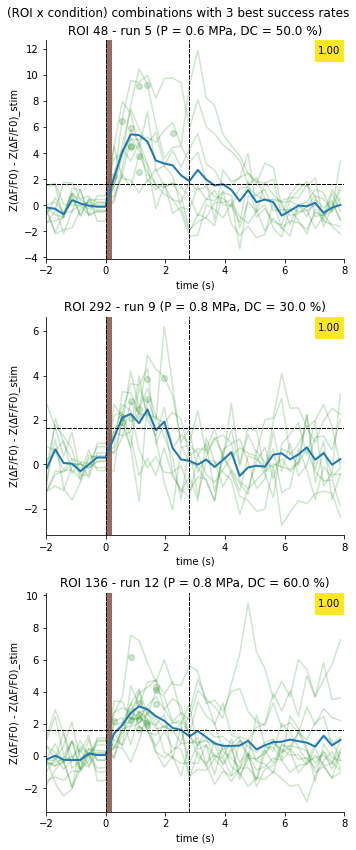

In [53]:
# Group by ROI and run, take first, sort by success rate, and select n bests 
best_sr = sr.sort_values(ascending=False).head(3)
logger.info(f'identified combinations with best success rate:\n{best_sr}')
ibests = best_sr.index.values
figs['best_responders'], axes = plt.subplots(len(ibests), 1, figsize=(5, len(ibests) * 4))
for comb, ax in zip(ibests, axes):
    fig = plot_responses(
        plt_data, iROI=comb[0], irun=comb[1],
        alltraces=True, ykey=Label.REL_ZSCORE, label=Label.SUCCESS_RATE,
        mark_peaks=True, ci=None,
        tbounds=tbounds_response, ax=ax)
fig.suptitle(f'(ROI x condition) combinations with {len(ibests)} best success rates')
fig.tight_layout()

### Response type, pressure & duty cycle dependency

 13/12/2021 13:15:07: sub-indexing data...
 13/12/2021 13:15:08: filtering data...
 13/12/2021 13:15:09: cross-checking filters...
 13/12/2021 13:15:10: grouping by response type, averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 13/12/2021 13:15:52: sub-indexing data...
 13/12/2021 13:15:53: filtering data...
 13/12/2021 13:15:54: cross-checking filters...
 13/12/2021 13:15:54: grouping by response type, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 13/12/2021 13:16:19: sub-indexing data...
 13/12/2021 13:16:21: filtering data...
 13/12/2021 13:16:22: cross-checking filters...
 13/12/2021 13:16:22: grouping by response type, grouping by DC (%), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 13/12/2021 13:16:54: sub-indexing data...
 13/12/2021 13:16:56: filtering data...
 13/12/2021 13:16:57: cross

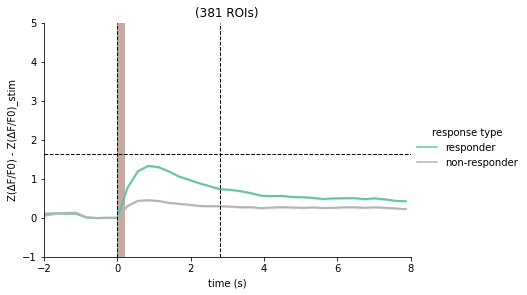

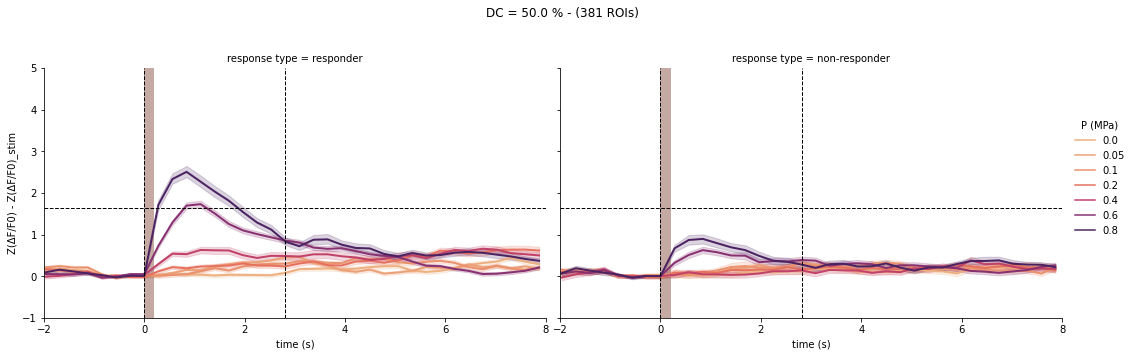

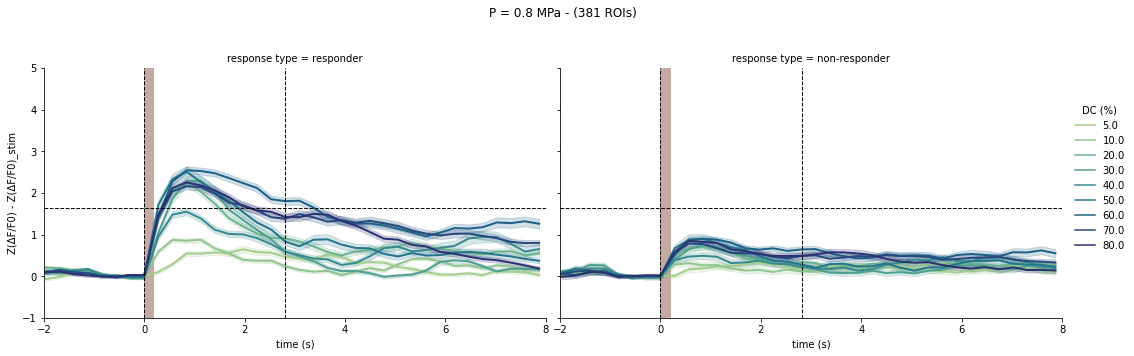

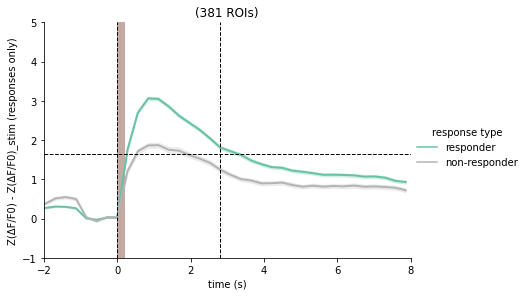

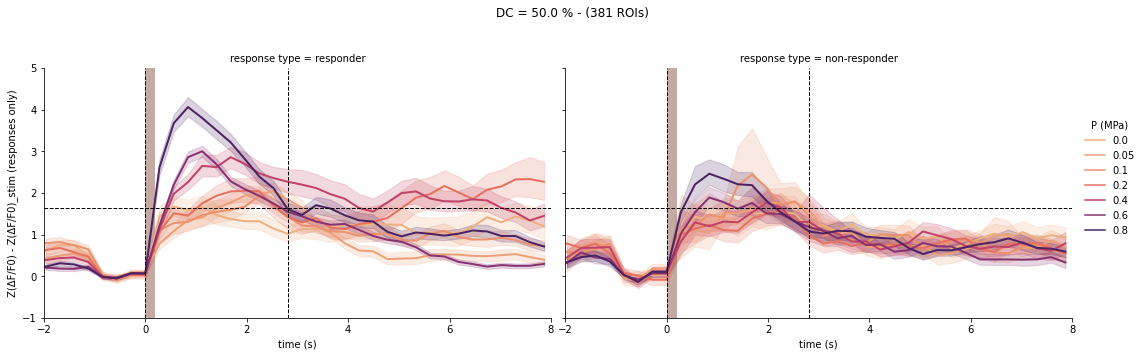

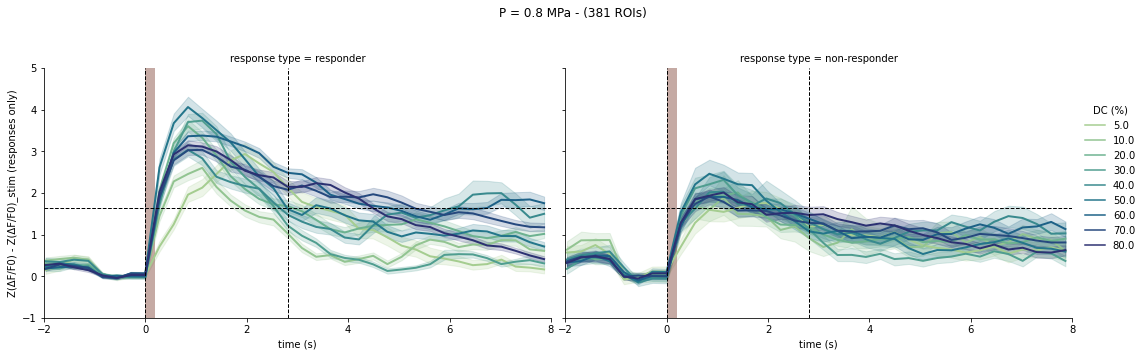

In [54]:
for ykey in [Label.REL_ZSCORE, Label.REL_ZSCORE_RESPONLY]:
    # Across conditions
    figs[f'responses_{ykey}_by_type'] = plot_responses(
        plt_data, ykey=ykey,
        hue=Label.ROI_RESP_TYPE,
        tbounds=tbounds_response,
        ybounds=ybounds_response)

    # Pressure dependency
    figs[f'responses_{ykey}_by_type_DC{DC_REF}%'] = plot_responses(
        plt_data, DC=DC_REF, ykey=ykey,
        hue=Label.P, col=Label.ROI_RESP_TYPE,
        tbounds=tbounds_response,
        ybounds=ybounds_response)

    # Duty cycle dependency
    figs[f'responses_{ykey}_by_type_P{P_REF}MPa'] = plot_responses(
        plt_data, P=P_REF, ykey=ykey,
        hue=Label.DC, col=Label.ROI_RESP_TYPE,
        tbounds=tbounds_response,
        ybounds=ybounds_response)

## Parameter dependency of response metrics

### Extract trial-averaged data

In [55]:
logger.info('computing trial-averaged data...')
trialavg_data = get_trial_averaged(noprestim_data)
logger.info('trial-averaged data:')
trialavg_data

 13/12/2021 13:17:48: computing trial-averaged data...
 13/12/2021 13:18:12: trial-averaged data:


line  duration (s)  P (MPa)  DC (%)  run ID  F_ROI (a.u.)  \
ROI run                                                               
1   0    line3           0.2     0.00    50.0   869.0    118.278557   
    1    line3           0.2     0.10    50.0   867.0    121.767044   
    2    line3           0.2     0.20    50.0   866.0    118.206795   
    3    line3           0.2     0.40    50.0   865.0    119.154320   
    4    line3           0.2     0.05    50.0   868.0    124.364830   
...        ...           ...      ...     ...     ...           ...   
742 10   line3           0.2     0.80    40.0   856.0    145.838074   
    11   line3           0.2     0.80    50.0   855.0    151.037247   
    12   line3           0.2     0.80    60.0   861.0    135.291779   
    13   line3           0.2     0.80    70.0   862.0    134.855988   
    14   line3           0.2     0.80    80.0   863.0    131.731812   

         F_neu (a.u.)  alpha   F (a.u.)  F0 (a.u.)  ...  \
ROI run                                             ...   
1   0      112.622101    0.7  39.758666  34.693394  ...   
    1      113.104446    0.7  42.545397  35.832772  ...   
    2      111.152344    0.7  40.947362  34.460274  ...   
    3      111.351318    0.7  41.005399  34.531903  ...   
    4      111.697540    0.7  47.082480  40.104988  ...   
...               ...    ...        ...        ...  ...   
742 10     133.017120    0.7  52.989932  48.046936  ...   
    11     137.438950    0.7  54.921243  50.115795  ...   
    12     128.219391    0.7  45.595136  40.698296  ...   
    13     127.318611    0.7  45.715606  41.007215  ...   
    14     126.722008    0.7  43.282965  38.802760  ...   

         Z(ΔF/F0) - Z(ΔF/F0)_stim  Z(ΔF/F0) - Z(ΔF/F0)_stim (responses only)  \
ROI run                                                                        
1   0                    0.353909                                        NaN   
    1                    0.698148                                   1.115315   
    2                    0.760705                                   0.808715   
    3                    0.445611                                   2.384394   
    4                    0.665172                                   0.797564   
...                           ...                                        ...   
742 10                   0.598228                                   0.860018   
    11                   0.609077                                   0.979752   
    12                   0.743439                                   1.001432   
    13                   0.180608                                   0.565364   
    14                   0.300012                                   0.618423   

         max pre-stim Z(ΔF/F0)  pre-stim rate  \
ROI run                                         
1   0                 0.472725            0.0   
    1                 0.582977            0.0   
    2                 0.706683            0.0   
    3                 0.695077            0.0   
    4                 0.226422            0.0   
...                        ...            ...   
742 10                0.403406            0.0   
    11                0.282029            0.0   
    12                0.147946            0.0   
    13                0.590842            0.0   
    14                0.621000            0.0   

         peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]  success rate  \
ROI run                                                            
1   0                                     0.441299      0.000000   
    1                                     0.627448      0.307692   
    2                                     0.930040      0.333333   
    3                                     1.705504      0.272727   
    4                                     1.212426      0.181818   
...                                            ...           ...   
742 10                                    1.805436      0.545455   
    11                     

### Success rate

 13/12/2021 13:18:12: sub-indexing data...
 13/12/2021 13:18:12: filtering data...
 13/12/2021 13:18:12: cross-checking filters...
 13/12/2021 13:18:12: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. P (MPa) ...
 13/12/2021 13:18:12: sub-indexing data...
 13/12/2021 13:18:12: filtering data...
 13/12/2021 13:18:12: cross-checking filters...
 13/12/2021 13:18:12: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. DC (%) ...


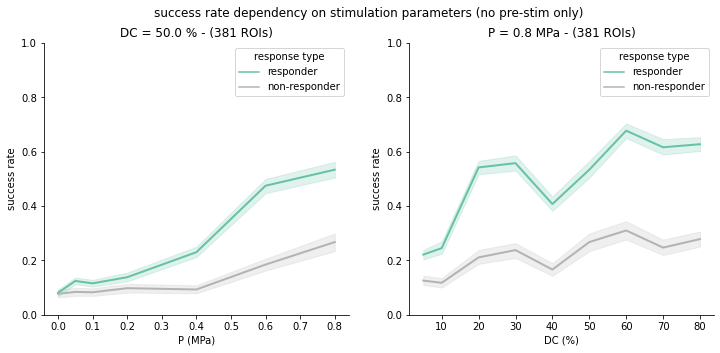

In [56]:
ykey = Label.SUCCESS_RATE
figs['success_rate_dependency'], axes = plt.subplots(1, 2, figsize=(12, 5))
for xkey, ax in zip([Label.P, Label.DC], axes):
    fig = plot_parameter_dependency(
        trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, 1), hue=Label.ROI_RESP_TYPE,
        ax=ax)
fig.suptitle('success rate dependency on stimulation parameters (no pre-stim only)');

### Peak dFF z-score

 13/12/2021 13:18:12: sub-indexing data...
 13/12/2021 13:18:12: filtering data...
 13/12/2021 13:18:12: cross-checking filters...
 13/12/2021 13:18:12: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. P (MPa) ...
 13/12/2021 13:18:13: sub-indexing data...
 13/12/2021 13:18:13: filtering data...
 13/12/2021 13:18:13: cross-checking filters...
 13/12/2021 13:18:13: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. DC (%) ...


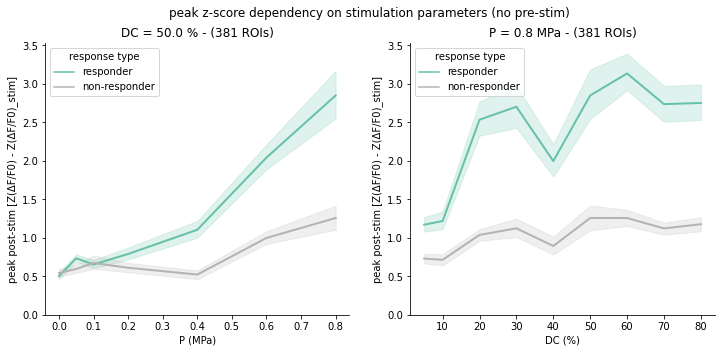

In [57]:
ykey = Label.PEAK_REL_ZSCORE_POSTSTIM
figs['peak_zscore_dependency'], axes = plt.subplots(1, 2, figsize=(12, 5))
for xkey, ax in zip([Label.P, Label.DC], axes.T):
    fig = plot_parameter_dependency(
        trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, None), hue=Label.ROI_RESP_TYPE,
        ax=ax)
harmonize_axes_limits(axes)
fig.suptitle('peak z-score dependency on stimulation parameters (no pre-stim)');

### Peak dFF z-score (responses only, raw and weighted by success rate)

 13/12/2021 13:18:13: sub-indexing data...
 13/12/2021 13:18:13: filtering data...
 13/12/2021 13:18:13: cross-checking filters...
 13/12/2021 13:18:13: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) vs. P (MPa) ...
 13/12/2021 13:18:13: sub-indexing data...
 13/12/2021 13:18:13: filtering data...
 13/12/2021 13:18:13: cross-checking filters...
 13/12/2021 13:18:13: grouping by response type, weighting by success rate, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) vs. P (MPa) ...
 13/12/2021 13:18:14: sub-indexing data...
 13/12/2021 13:18:14: filtering data...
 13/12/2021 13:18:14: cross-checking filters...
 13/12/2021 13:18:14: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) vs. DC (%) ...
 13/12/2021 13:18:14: sub-

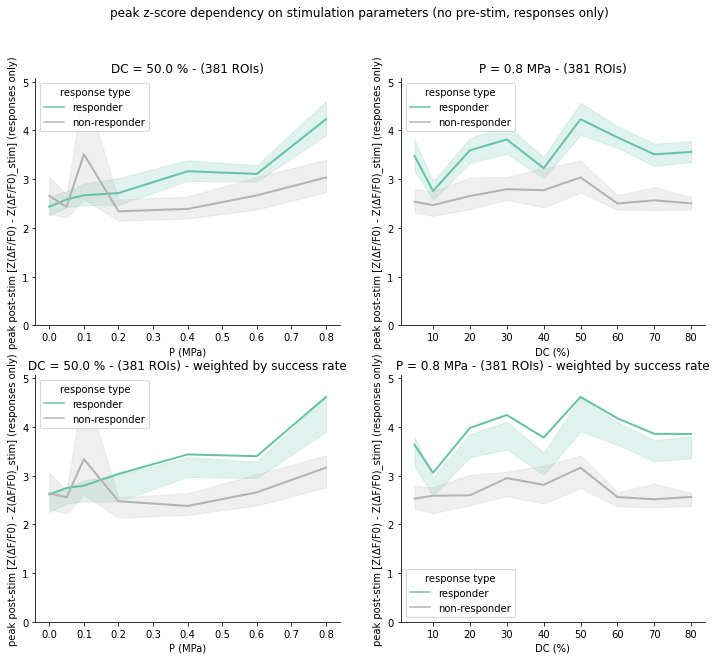

In [58]:
ykey = Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY
figs['peak_zscore_responly_dependency'], axes = plt.subplots(2, 2, figsize=(12, 10))
for xkey, axrow in zip([Label.P, Label.DC], axes.T):
    for weightby, ax in zip([None, Label.SUCCESS_RATE], axrow):
        fig = plot_parameter_dependency(
            trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, None), hue=Label.ROI_RESP_TYPE,
            weightby=weightby, ax=ax)
harmonize_axes_limits(axes)
fig.suptitle('peak z-score dependency on stimulation parameters (no pre-stim, responses only)');

### Save figures

In [59]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs)

 13/12/2021 13:18:15: saving figure "dataset_info" on page 0
 13/12/2021 13:18:15: saving figure "raw_stack_frames_run4" on page 1
 13/12/2021 13:18:15: saving figure "raw_stack_hist_run4" on page 2
 13/12/2021 13:18:15: saving figure "raw_stack_fspectrum_run4" on page 3
 13/12/2021 13:18:15: saving figure "raw_stack_timecourse_run4" on page 4
 13/12/2021 13:18:15: saving figure "interp_stack_frames_run4" on page 5
 13/12/2021 13:18:15: saving figure "interp_stack_hist_run4" on page 6
 13/12/2021 13:18:16: saving figure "interp_stack_fspectrum_run4" on page 7
 13/12/2021 13:18:16: saving figure "interp_stack_timecourse_run4" on page 8
 13/12/2021 13:18:16: saving figure "filtered_stack_frames_run4" on page 9
 13/12/2021 13:18:16: saving figure "filtered_stack_hist_run4" on page 10
 13/12/2021 13:18:16: saving figure "filtered_stack_fspectrum_run4" on page 11
 13/12/2021 13:18:16: saving figure "filtered_stack_timecourse_run4" on page 12
 13/12/2021 13:18:17: saving figure "registered_i

### Save stacks as GIFs

In [60]:
# #raw and fileted stacks from specific run
# save_stack_to_gif(
#     figsdir, {'raw': raw_stack_fpaths[ifile], 'filtered': filtered_stack_fpaths[ifile]},
#     ilabels=i_stim_frames_run)
# # registered stack (slice corresponding to specific run)
# save_stack_to_gif(
#     figsdir, s2p_ops, title=outstack_label,
#     ilabels=istimframes_stacked, bounds=runbounds)

### Notify upon completion

In [61]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'notebook completed in {tstamp_end - tstamp_start} s'
jupyter_slack.notify_self(s)
logger.info(s)

 13/12/2021 13:18:47: notebook completed in 0:08:13.046907 s
